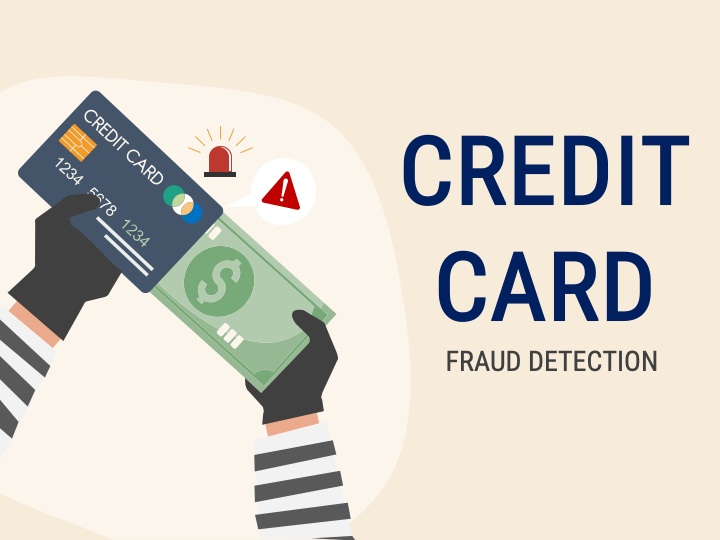

#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import ShuffleSplit, learning_curve

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report,make_scorer
from sklearn.metrics import roc_curve, roc_auc_score


from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

import pickle
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

#Import data

In [ ]:
train = pd.read_csv('/content/fraudTrain.csv')
test = pd.read_csv('/content/fraudTest.csv')
print(train.shape,test.shape)

(1296675, 23) (555719, 23)


#Data preprocesing

In [ ]:
df = pd.concat([train,test],axis = 0)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
df.shape

(1852394, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud               i

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
new_headers = {
    'trans_date_trans_time': 'transaction_time',
    'cc_num': 'account_number',
    'merchant': 'merchant_name',
    'category': 'category',
    'amt': 'transaction_amount',
    'first': 'first_name',
    'last': 'last_name',
    'gender': 'gender',
    'street': 'street',
    'city': 'city',
    'state': 'state',
    'zip': 'zip',
    'lat': 'client_latitude',
    'long': 'client_longitude',
    'city_pop': 'city_population',
    'job': 'job',
    'dob': 'birthday',
    'trans_num': 'transaction_number',
    'unix_time': 'unix_time',
    'merch_lat': 'merchant_latitude',
    'merch_long': 'merchant_longitude',
    'is_fraud': 'is_fraud',
}
df.rename(columns=new_headers, inplace=True)

In [ ]:
df.transaction_time = pd.to_datetime(df.transaction_time)
df.birthday = pd.to_datetime(df.birthday)

In [ ]:
def calculate_age(born, trans_date):
    age = trans_date.year - born.year - ((trans_date.month, trans_date.day) < (born.month, born.day))
    return age

df['age'] = df.apply(lambda row: calculate_age(row['birthday'], row['transaction_time']), axis=1)


In [ ]:
df['transaction_hour'] = df['transaction_time'].dt.hour
df['transaction_day'] = df['transaction_time'].dt.day
df['transaction_month'] = df['transaction_time'].dt.month

In [ ]:
df['transaction_distance'] = np.sqrt((df.merchant_longitude - df.client_longitude)**2 + (df.merchant_latitude - df.client_latitude)**2)

In [ ]:
columns_to_drop = ['account_number', 'birthday','merchant_latitude','merchant_longitude','client_latitude','client_longitude','first_name','last_name','transaction_number','unix_time','street','merchant_name']
df = df.drop(columns=columns_to_drop)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 15 columns):
 #   Column                Dtype         
---  ------                -----         
 0   transaction_time      datetime64[ns]
 1   category              object        
 2   transaction_amount    float64       
 3   gender                object        
 4   city                  object        
 5   state                 object        
 6   zip                   int64         
 7   city_population       int64         
 8   job                   object        
 9   is_fraud              int64         
 10  age                   int64         
 11  transaction_hour      int32         
 12  transaction_day       int32         
 13  transaction_month     int32         
 14  transaction_distance  float64       
dtypes: datetime64[ns](1), float64(2), int32(3), int64(4), object(5)
memory usage: 204.9+ MB


In [ ]:
df.isna().sum()

,0
transaction_time,0
category,0
transaction_amount,0
gender,0
city,0
state,0
zip,0
city_population,0
job,0
is_fraud,0


In [ ]:
df.duplicated().sum()

0

#train test split

In [ ]:
df_train = df.iloc[:train.shape[0], :]
df_test = df.iloc[train.shape[0]:, :]
print(df_train.shape,df_test.shape)

(1296675, 15) (555719, 15)


#Explarotary Data Analysis

In [ ]:
df_train.describe().T

,count,mean,min,25%,50%,75%,max,std
transaction_time,1296675,2019-10-03 12:47:28.070214144,2019-01-01 00:00:18,2019-06-03 19:12:22.500000,2019-10-03 07:35:47,2020-01-28 15:02:55.500000,2020-06-21 12:13:37,NaN
transaction_amount,1296675.0,70.351035,1.0,9.65,47.52,83.14,28948.9,160.316039
zip,1296675.0,48800.671097,1257.0,26237.0,48174.0,72042.0,99783.0,26893.222476
city_population,1296675.0,88824.440563,23.0,743.0,2456.0,20328.0,2906700.0,301956.360689
is_fraud,1296675.0,0.005789,0.0,0.0,0.0,0.0,1.0,0.075863
age,1296675.0,45.496879,13.0,32.0,43.0,57.0,95.0,17.397023
transaction_hour,1296675.0,12.804858,0.0,7.0,14.0,19.0,23.0,6.817824
transaction_day,1296675.0,15.587978,1.0,8.0,15.0,23.0,31.0,8.829121
transaction_month,1296675.0,6.14215,1.0,3.0,6.0,9.0,12.0,3.417703
transaction_distance,1296675.0,0.765661,0.000239,0.564958,0.798311,0.977536,1.413364,0.284748


##EDA sur l'ensemble de données d'entrainement

###corrélation

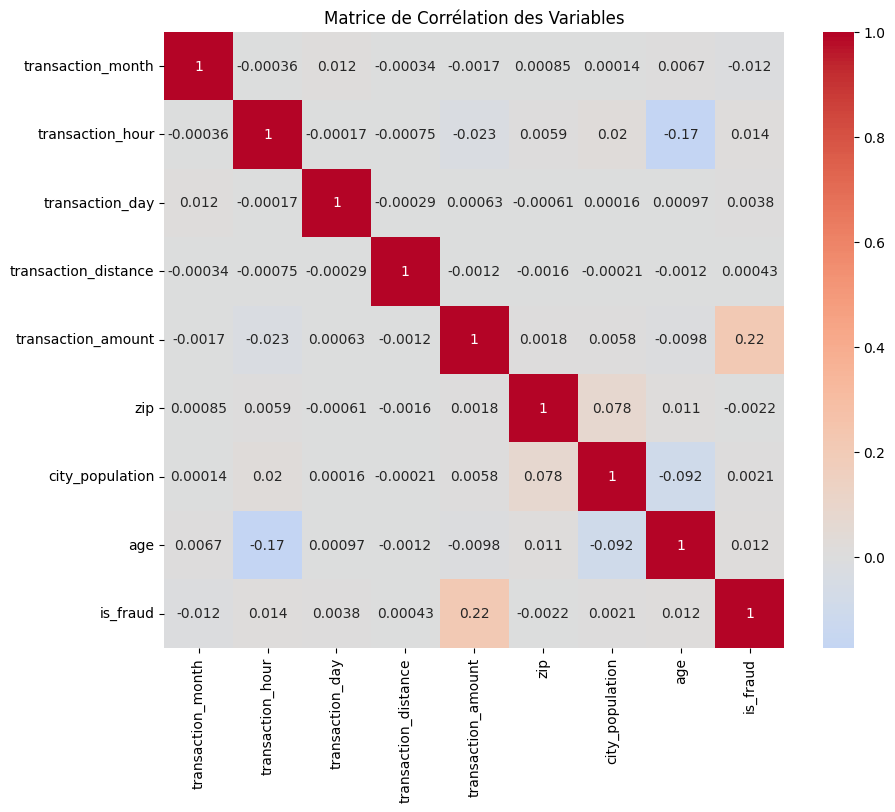

In [ ]:
corrmat = df_train[['transaction_month','transaction_hour','transaction_day','transaction_distance','transaction_amount','zip','city_population','age','is_fraud']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corrmat, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation des Variables')
plt.show()

**le seul feature qui a une corrélation modérée avec la cible est transaction_amount**

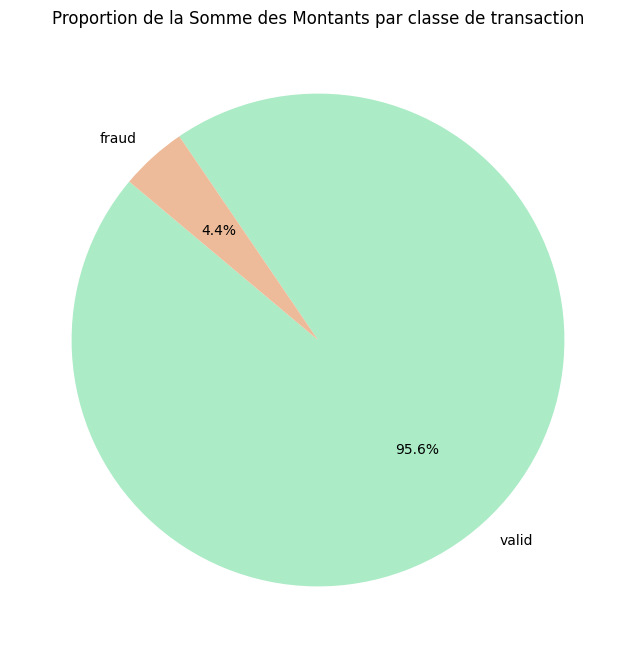

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(df_train.groupby('is_fraud')['transaction_amount'].sum(), labels=['valid','fraud'], autopct='%1.1f%%', startangle=140, colors =['#abebc6','#edbb99'])
plt.title('Proportion de la Somme des Montants par classe de transaction')
plt.show()

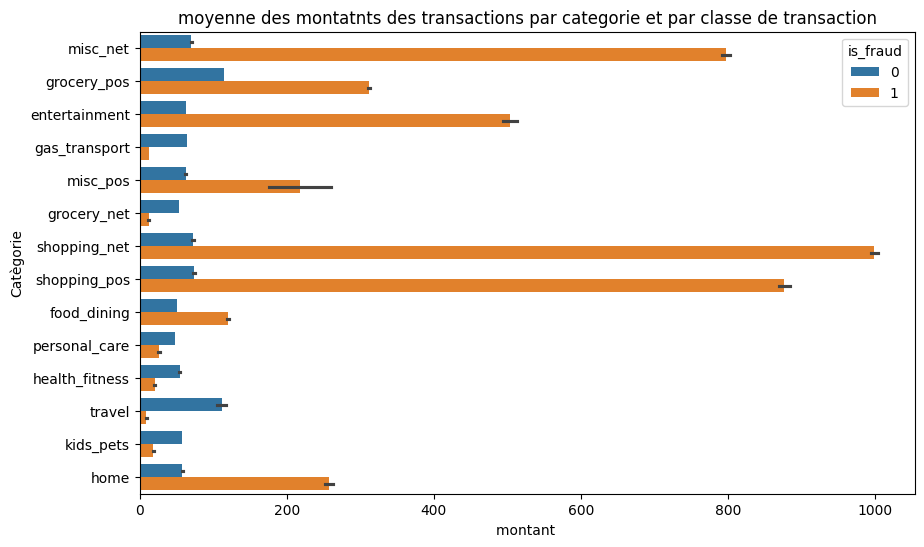

In [ ]:
plt.figure(figsize=(10,6))
g = sns.barplot(data=df_train,x='transaction_amount',y='category', hue='is_fraud')
g.set_title('moyenne des montatnts des transactions par categorie et par classe de transaction')
g.set_xlabel('montant ')
g.set_ylabel('Catègorie')
sns.set_palette(['#abebc6','#edbb99'])

plt.show()

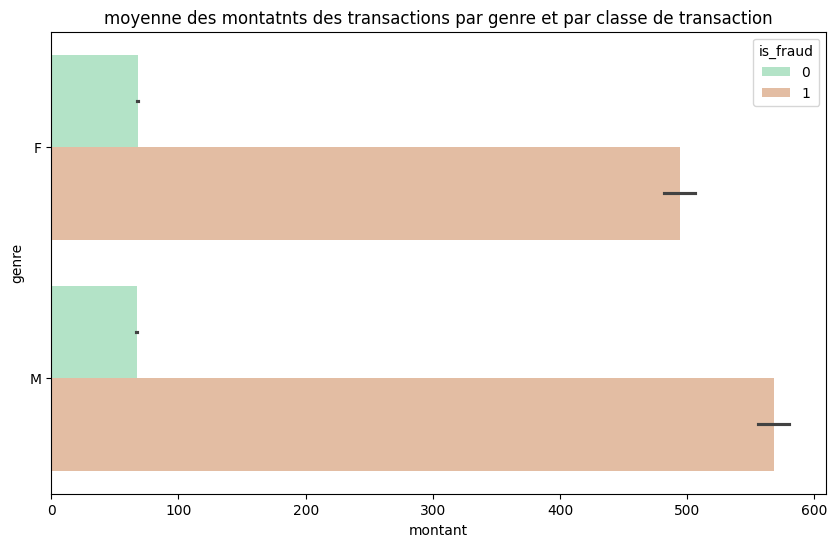

In [ ]:
plt.figure(figsize=(10,6))
g = sns.barplot(data=df_train,x='transaction_amount',y='gender', hue='is_fraud')
g.set_title('moyenne des montatnts des transactions par genre et par classe de transaction')
g.set_xlabel('montant')
g.set_ylabel('genre')
sns.set_palette(['#abebc6','#edbb99'])

plt.show()

##EDA sur les données des transactions frauduleuses

###selection des transaction frauduleuses

In [ ]:
df_train_fraud = df_train[df_train['is_fraud']==1]
df_train_fraud.shape

(7506, 15)

###Distribution des variables numériques

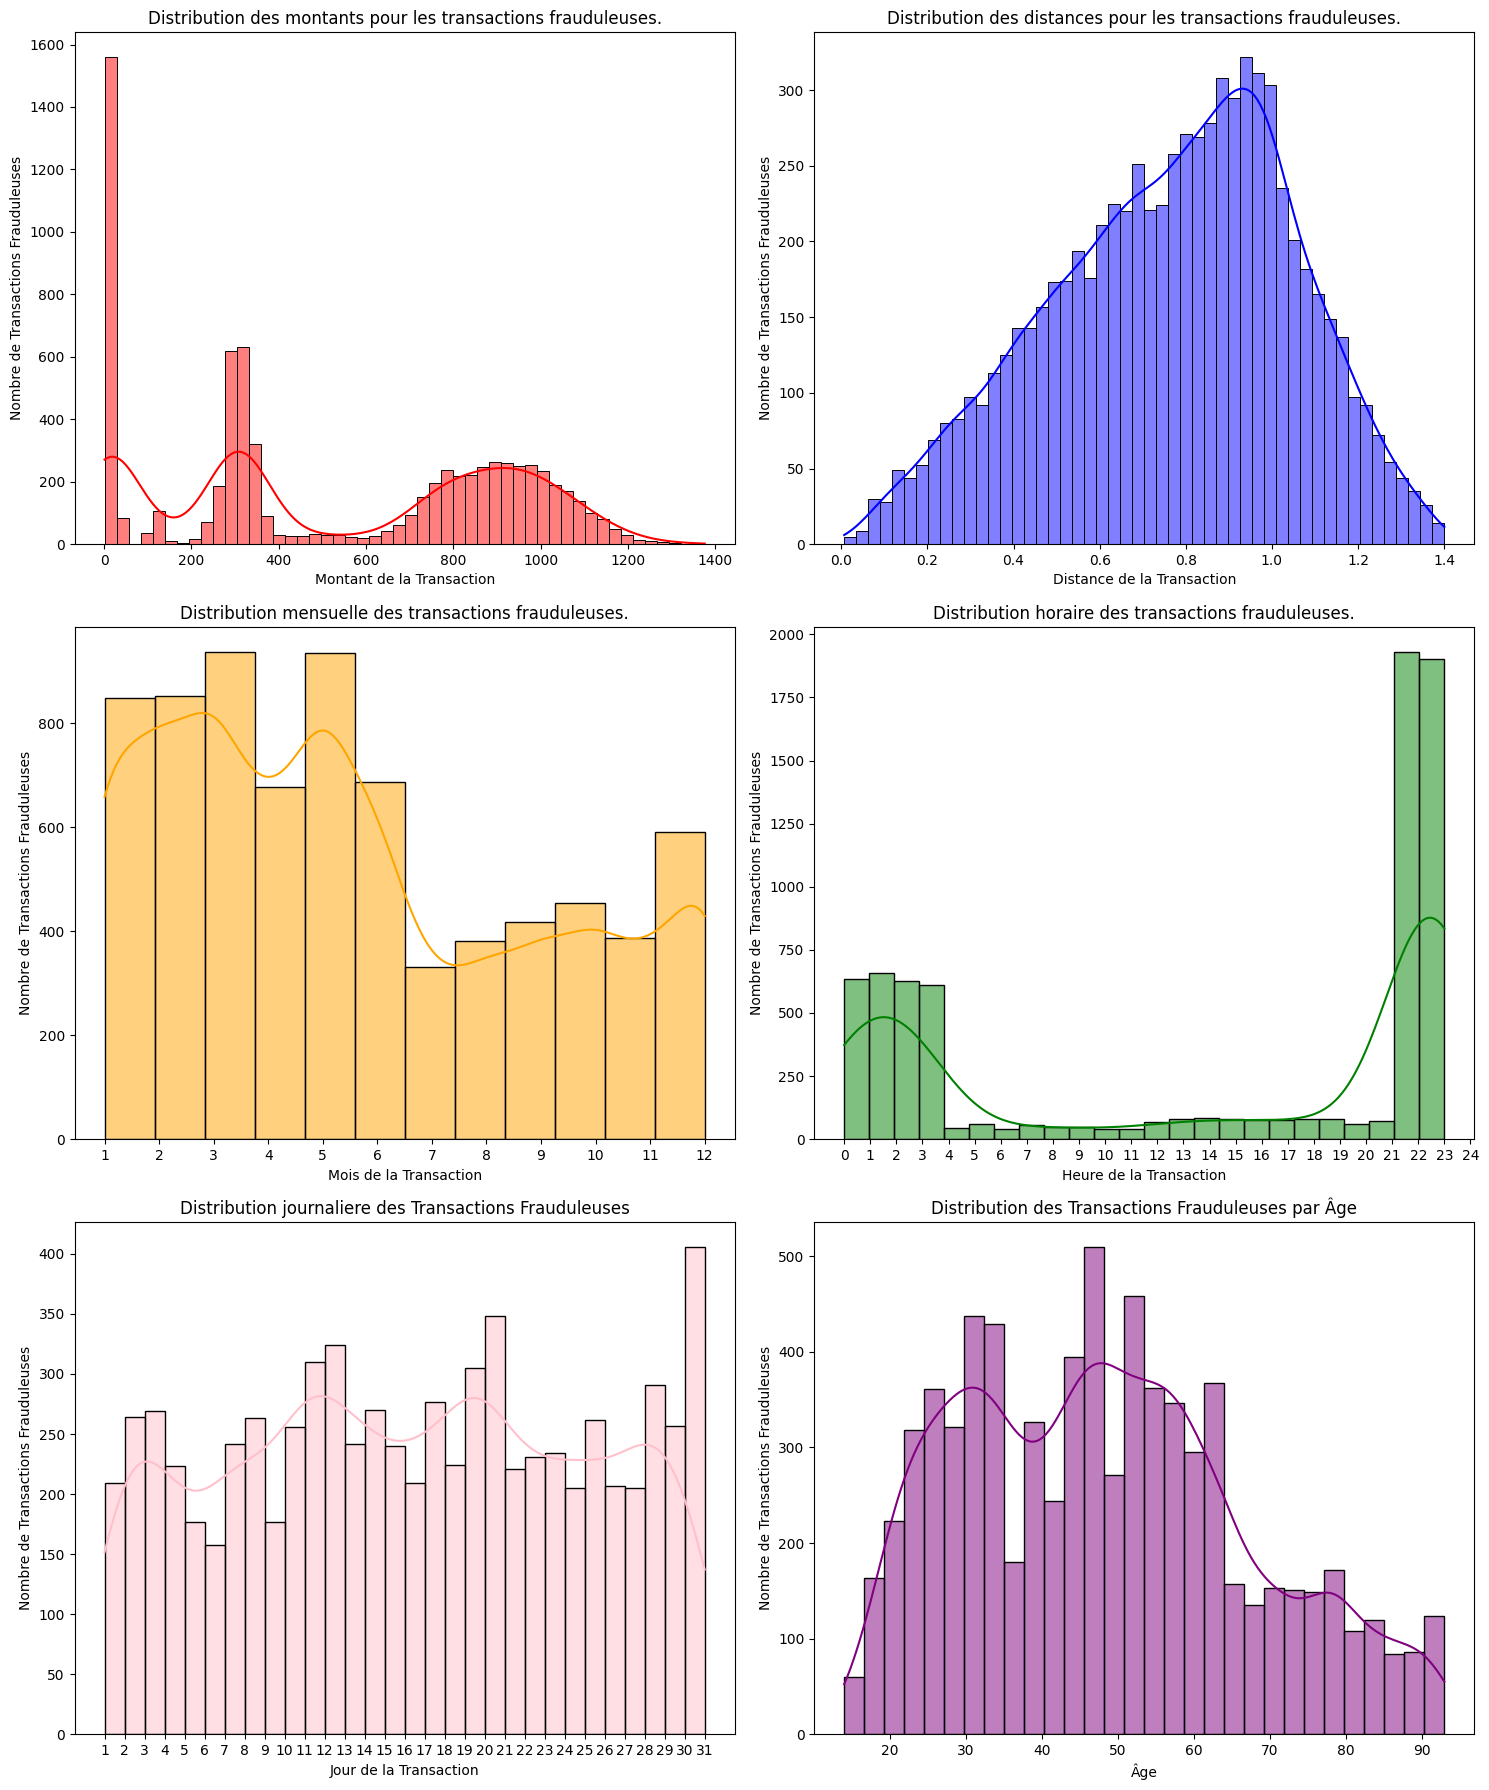

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Distribution des montants des transactions frauduleuses
sns.histplot(df_train_fraud['transaction_amount'], bins=50, kde=True, color='red', ax=axes[0, 0])
axes[0, 0].set_title('Distribution des montants pour les transactions frauduleuses.')
axes[0, 0].set_xlabel('Montant de la Transaction')
axes[0, 0].set_ylabel('Nombre de Transactions Frauduleuses')

# Distribution des distances des transactions frauduleuses
sns.histplot(df_train_fraud['transaction_distance'], bins=50, kde=True, color='blue', ax=axes[0, 1])
axes[0, 1].set_title('Distribution des distances pour les transactions frauduleuses.')
axes[0, 1].set_xlabel('Distance de la Transaction')
axes[0, 1].set_ylabel('Nombre de Transactions Frauduleuses')

# Distribution mensuelle des transactions frauduleuses.
sns.histplot(df_train_fraud['transaction_month'], bins=12, kde=True, color='orange', ax=axes[1, 0])
axes[1, 0].set_title('Distribution mensuelle des transactions frauduleuses.')
axes[1, 0].set_xlabel('Mois de la Transaction')
axes[1, 0].set_ylabel('Nombre de Transactions Frauduleuses')
axes[1, 0].set_xticks(range(1, 13))

# Distribution horaire des transactions frauduleuses
sns.histplot(df_train_fraud['transaction_hour'], bins=24, kde=True, color='green', ax=axes[1, 1])
axes[1, 1].set_title('Distribution horaire des transactions frauduleuses.')
axes[1, 1].set_xlabel('Heure de la Transaction')
axes[1, 1].set_ylabel('Nombre de Transactions Frauduleuses')
axes[1, 1].set_xticks(range(0, 25))

# Distribution journaliere des Transactions Frauduleuses
sns.histplot(df_train_fraud['transaction_day'], bins=30, kde=True, color='pink', ax=axes[2, 0])
axes[2, 0].set_title('Distribution journaliere des Transactions Frauduleuses')
axes[2, 0].set_xlabel('Jour de la Transaction')
axes[2, 0].set_ylabel('Nombre de Transactions Frauduleuses')
axes[2, 0].set_xticks(range(1, 32))

# Distribution des Transactions Frauduleuses par Âge
sns.histplot(df_train_fraud['age'], bins=30, kde=True, color='purple', ax=axes[2, 1])
axes[2, 1].set_title('Distribution des Transactions Frauduleuses par Âge')
axes[2, 1].set_xlabel('Âge')
axes[2, 1].set_ylabel('Nombre de Transactions Frauduleuses')

plt.tight_layout()
plt.show()

**Interprétations**


*   Il existe un pic notable pour les faibles montants ,Il exite un pic autour de 200-400 et il existe également un pic autour de 800-1000.

*   La distribution des distances est proche d'une distribution normale avec un pic autour de 0.8.((Les transactions frauduleuses se produisent souvent à une certaine distance moyenne.ces distances correspondent à des zones géographiques spécifiques.????))



*   Les transactions frauduleuses sont plus fréquentes au début de l'année (surtout entre janvier et mai) avec un pic notable en mai, suivi d'une diminution significative pour les mois qui suivent avant une légère augmentation à la fin de l'année.

*   La plupart des transactions frauduleuses se produisent en fin de journée(les heures tardives)



*   Les groupes d'âge les plus impliqués dans les fraudes sont 25-35 et 45-55.


*   chaque 3 jours on constate la présence d'une pic.








###Distribution des variables catégoriques

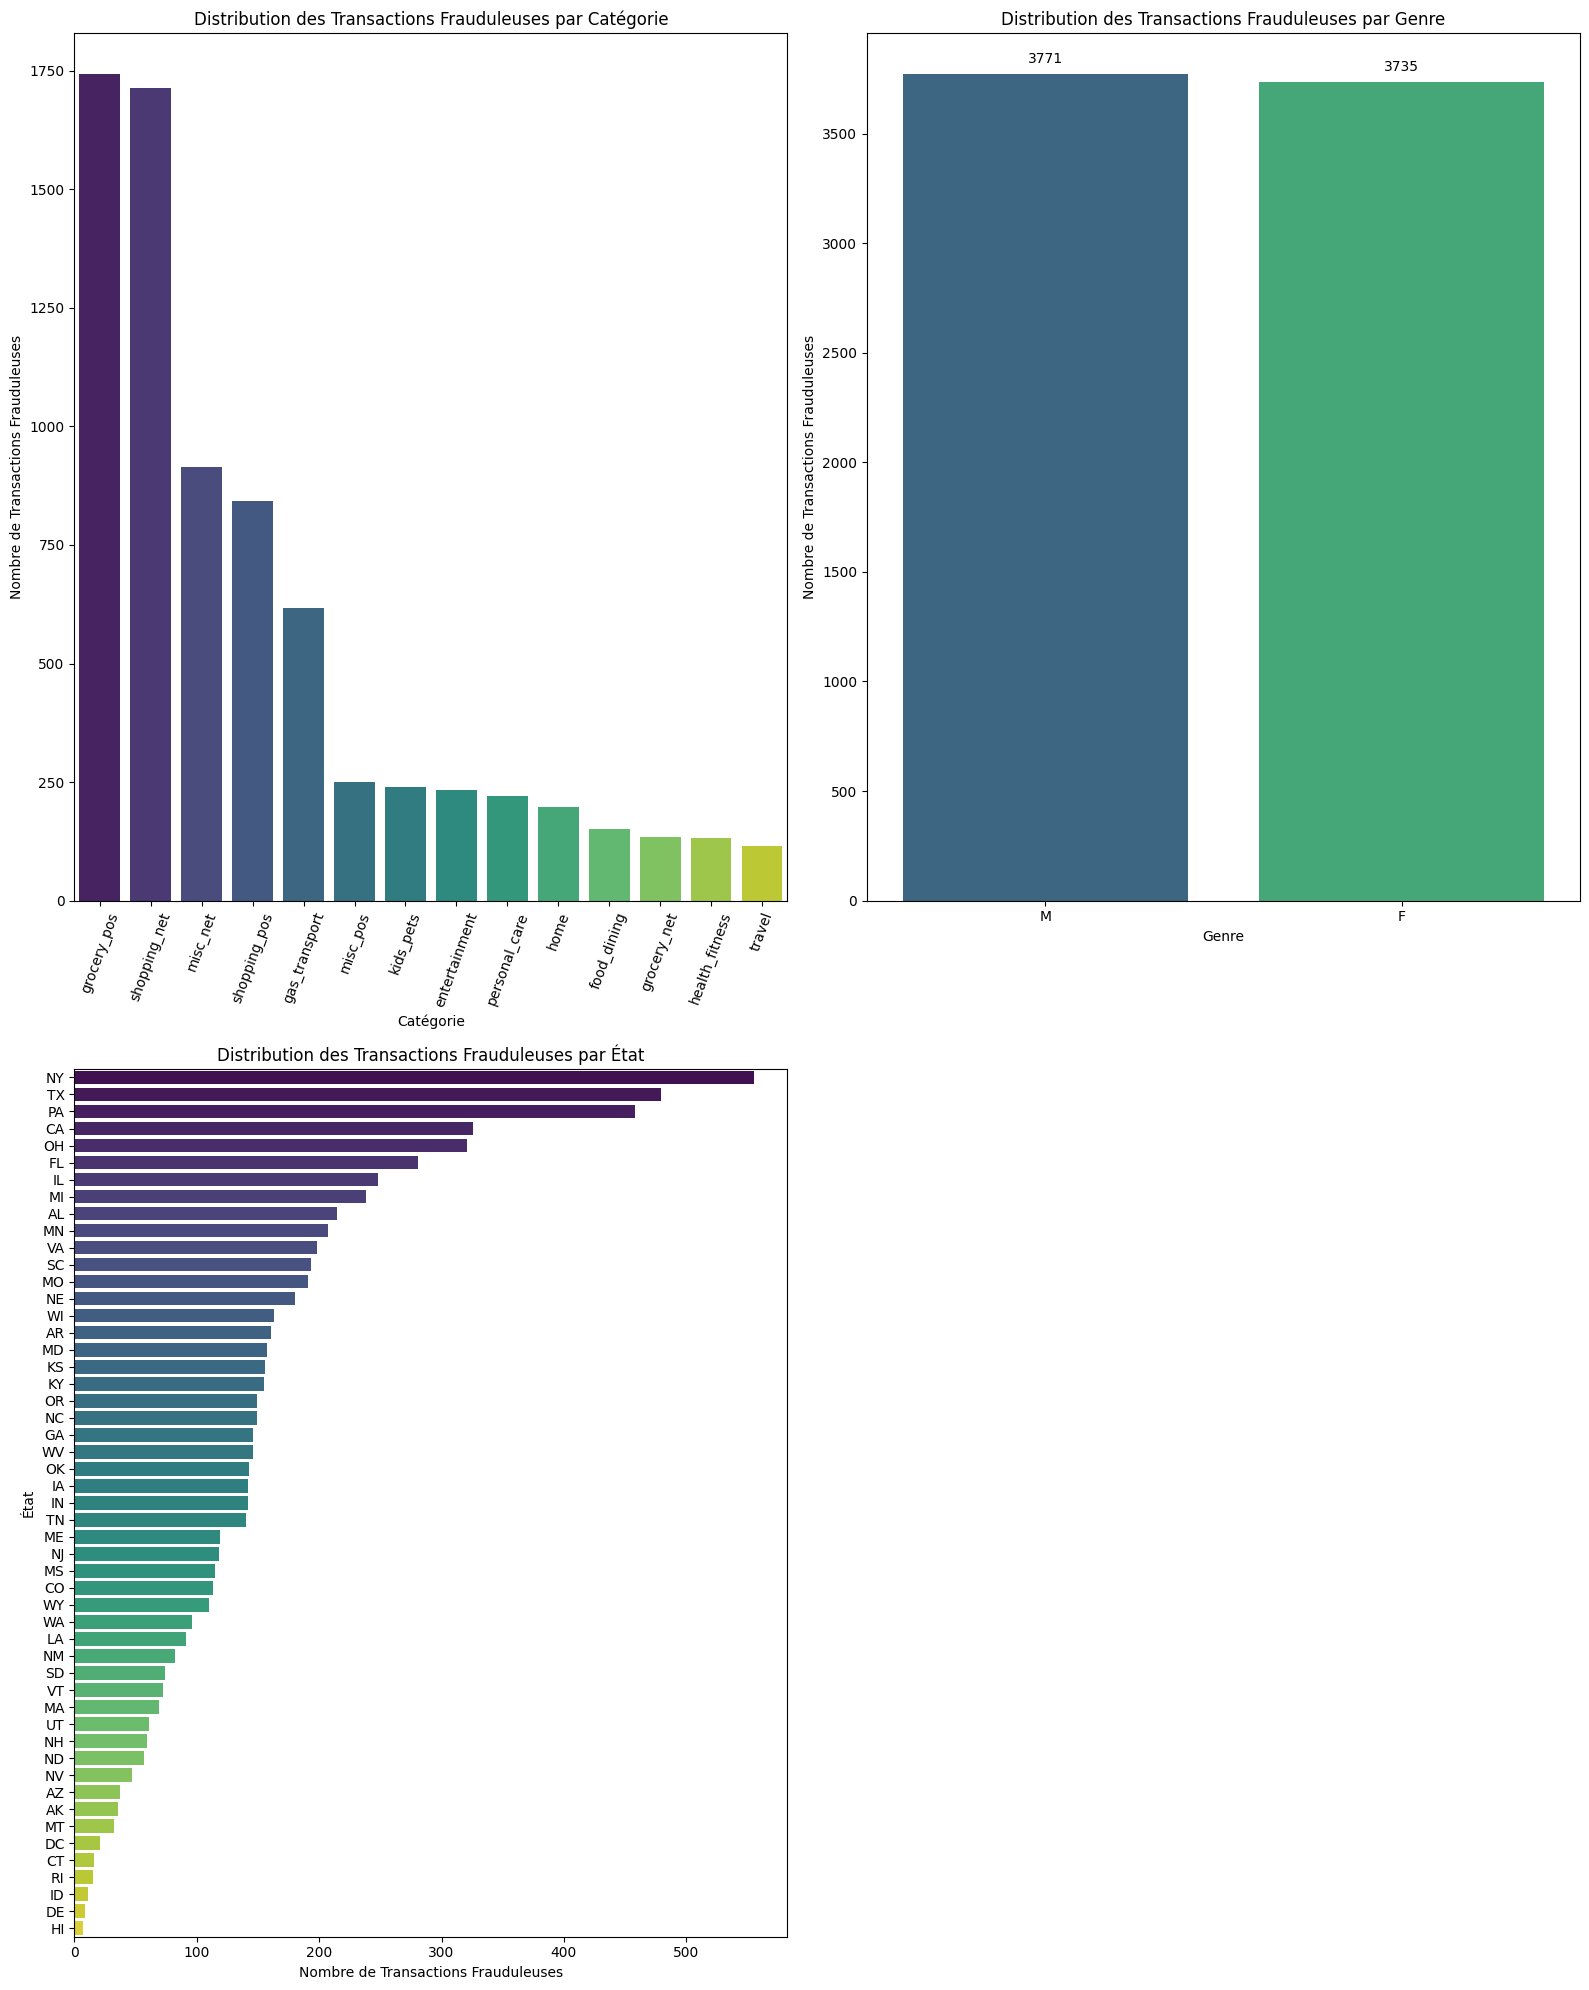

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 20))
sns.countplot(x='category', data=df_train_fraud,
              ax=axes[0, 0],
              palette='viridis',
              order=df_train_fraud['category'].value_counts().index)
axes[0, 0].set_title('Distribution des Transactions Frauduleuses par Catégorie')
axes[0, 0].set_xlabel('Catégorie')
axes[0, 0].set_ylabel('Nombre de Transactions Frauduleuses')
axes[0, 0].tick_params(axis='x', rotation=70)
ax = sns.countplot(x='gender', data=df_train_fraud,
                   ax=axes[0, 1],
                   palette='viridis',
                   order=df_train_fraud['gender'].value_counts().index)
axes[0, 1].set_title('Distribution des Transactions Frauduleuses par Genre')
axes[0, 1].set_xlabel('Genre')
axes[0, 1].set_ylabel('Nombre de Transactions Frauduleuses')
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.01 * height, str(int(height)),
            ha='center', va='bottom', fontsize=10)
sns.countplot(y='state', data=df_train_fraud,
              ax=axes[1, 0],
              palette='viridis',
              order=df_train_fraud['state'].value_counts().index)
axes[1, 0].set_title('Distribution des Transactions Frauduleuses par État')
axes[1, 0].set_xlabel('Nombre de Transactions Frauduleuses')
axes[1, 0].set_ylabel('État')

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()


**Interprétations**



*   Les catégories les plus touchées par les fraudes sont grocery_pos, gas_transport ,shopping_net, misc_net, et shopping_pos(Les fraudeurs semblent cibler principalement les achats courants et les ahats en ligne)

*   Il n'y a pas de différence significative entre les genres en termes de participation aux transactions frauduleuses.

*   NY,TX,PA,CA et OH concentrent un nombre disproportionnellement élevé de transactions frauduleuses par rapport aux autres etats.(Est ce que la population intervient t-elle????)






In [ ]:
len(df_train_fraud['job'].unique())

443

In [ ]:
len(df_train_fraud['city'].unique())

702

In [ ]:
fraud_by_job = df_train_fraud.groupby('job').size().reset_index(name='nbr_transactions_frauduleuses').sort_values(by='nbr_transactions_frauduleuses', ascending=False)
fraud_by_job.head(10)

,job,nbr_transactions_frauduleuses
256,Materials engineer,62
428,Trading standards officer,56
277,Naval architect,53
167,Exhibition designer,51
396,"Surveyor, land/geomatics",50
257,Mechanical engineer,49
316,Prison officer,48
345,Quantity surveyor,48
37,Audiological scientist,46
379,Senior tax professional/tax inspector,45


In [ ]:
fraud_by_city = df_train_fraud.groupby('city').size().reset_index(name='nbr_transactions_frauduleuses').sort_values(by='nbr_transactions_frauduleuses', ascending=False)
fraud_by_city

,city,nbr_transactions_frauduleuses
286,Houston,39
662,Warren,33
444,Naples,29
295,Huntsville,29
640,Topeka,27
...,...,...
643,Tupper Lake,3
516,Phenix City,2
165,Denham Springs,2
519,Phoenix,2


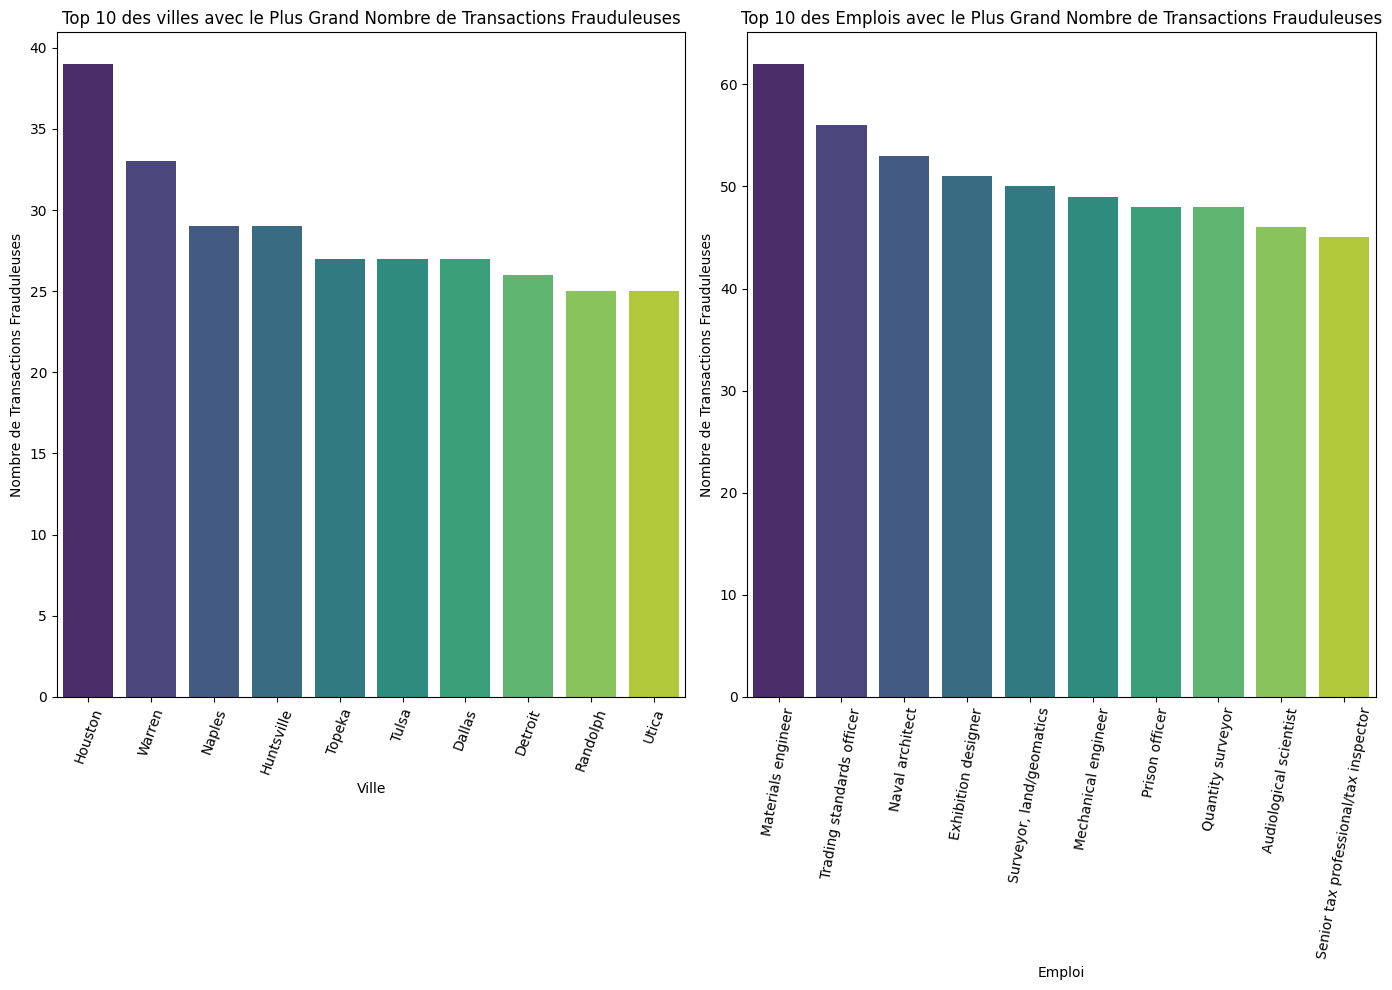

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# Distribution des transactions frauduleuses par ville (top 10)
sns.barplot(x='city', y='nbr_transactions_frauduleuses', data=fraud_by_city.head(10), ax=axes[0], palette='viridis')
axes[0].set_title('Top 10 des villes avec le Plus Grand Nombre de Transactions Frauduleuses')
axes[0].set_xlabel('Ville')
axes[0].set_ylabel('Nombre de Transactions Frauduleuses')
axes[0].tick_params(axis='x', rotation=70)

# Distribution des transactions frauduleuses par profession (top 10)
sns.barplot(x='job', y='nbr_transactions_frauduleuses', data=fraud_by_job.head(10), ax=axes[1], palette='viridis')
axes[1].set_title('Top 10 des Emplois avec le Plus Grand Nombre de Transactions Frauduleuses')
axes[1].set_xlabel('Emploi')
axes[1].set_ylabel('Nombre de Transactions Frauduleuses')
axes[1].tick_params(axis='x', rotation=80)

plt.tight_layout()
plt.show()

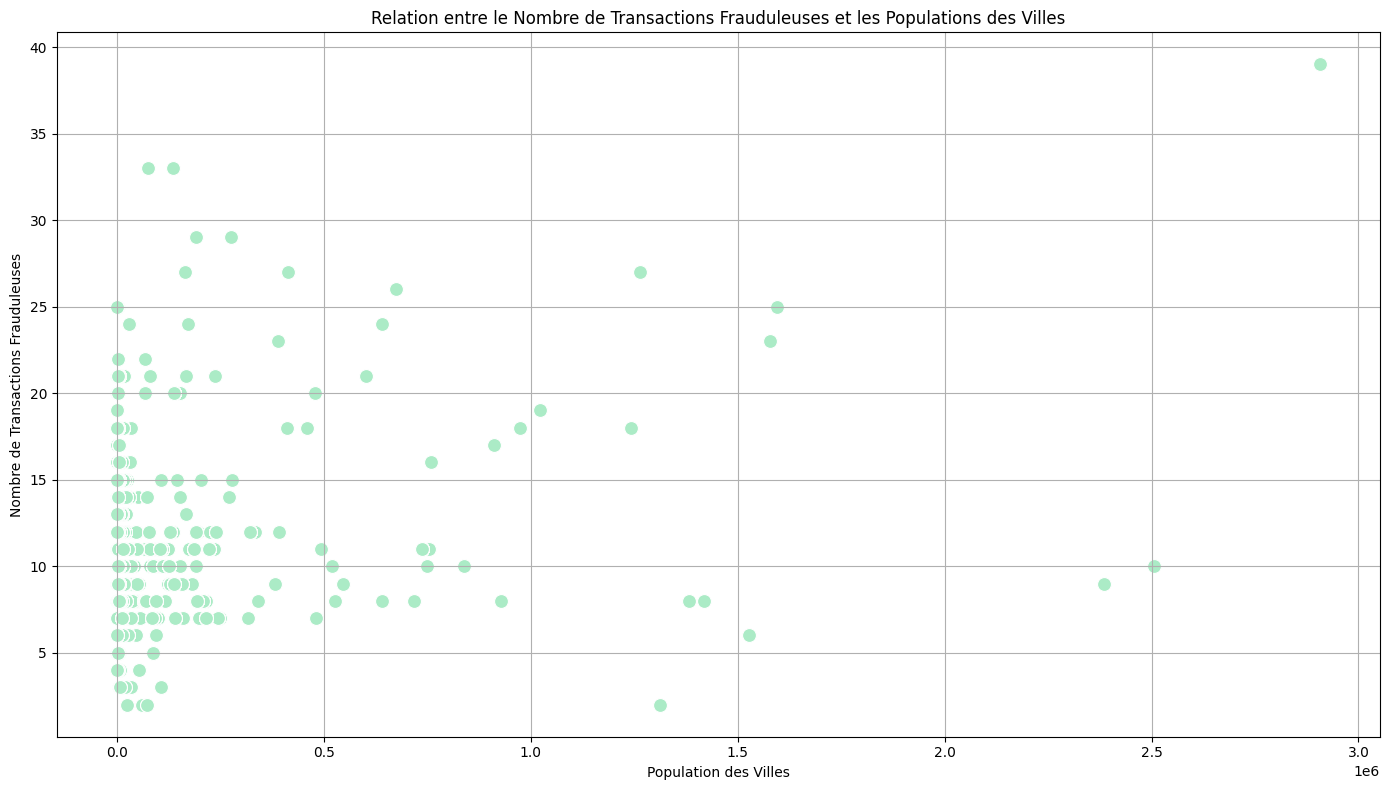

In [ ]:
city_data = pd.merge(fraud_by_city, df_train_fraud[['city', 'city_population']], on='city')
plt.figure(figsize=(14, 8))
sns.scatterplot(x='city_population', y='nbr_transactions_frauduleuses', data=city_data, s=100)
plt.title('Relation entre le Nombre de Transactions Frauduleuses et les Populations des Villes')
plt.xlabel('Population des Villes')
plt.ylabel('Nombre de Transactions Frauduleuses')
plt.grid(True)
plt.tight_layout()
plt.show()

 **Interprétation**


*   la densité résidentielle des villes et le nombre de transactions frauduleuses ne sont pas proportionelles





###Analyse multivaiée

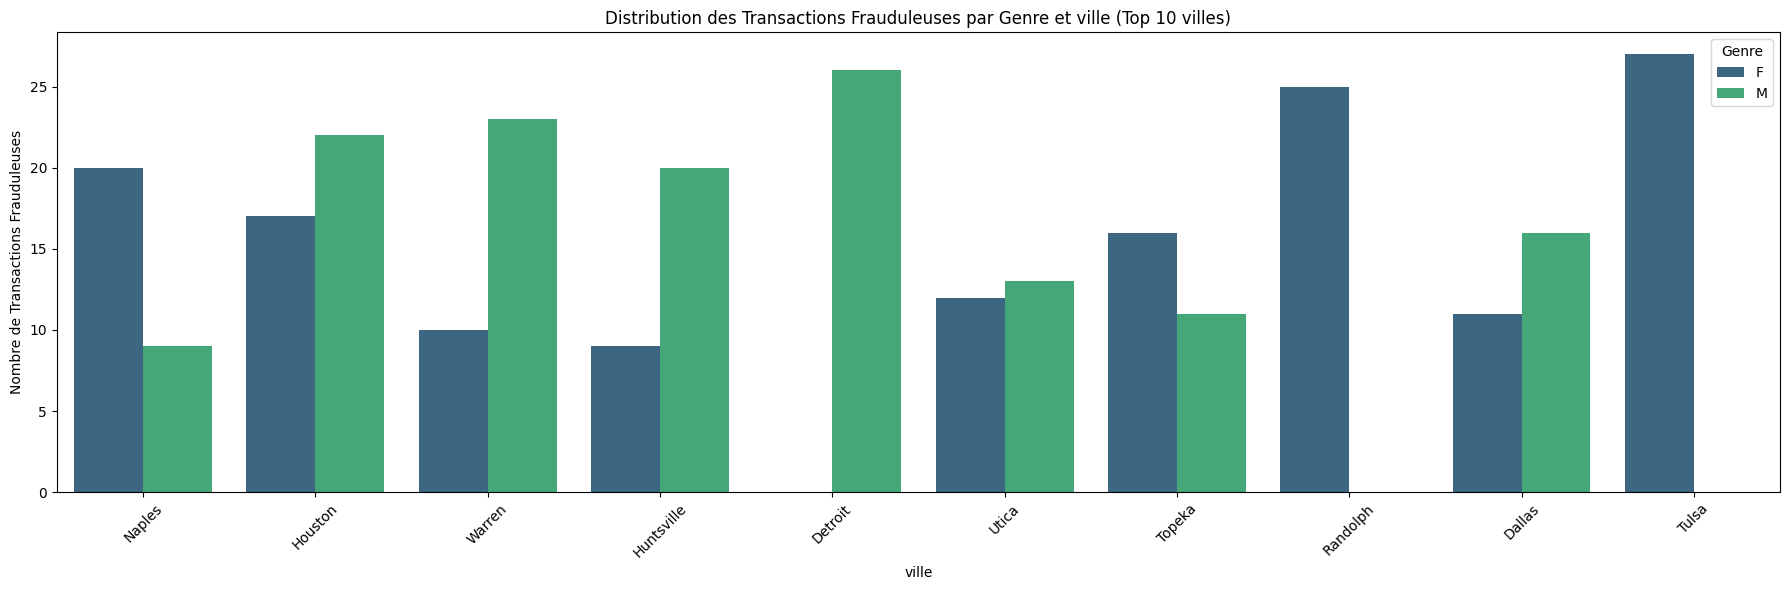

In [ ]:
plt.figure(figsize=(18, 6))
sns.countplot(x='city', hue='gender', data=df_train_fraud[df_train_fraud['city'].isin(df_train_fraud['city'].value_counts().nlargest(10).index)], palette='viridis')
plt.title('Distribution des Transactions Frauduleuses par Genre et ville (Top 10 villes)')
plt.xlabel('ville')
plt.ylabel('Nombre de Transactions Frauduleuses')
plt.legend(title='Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

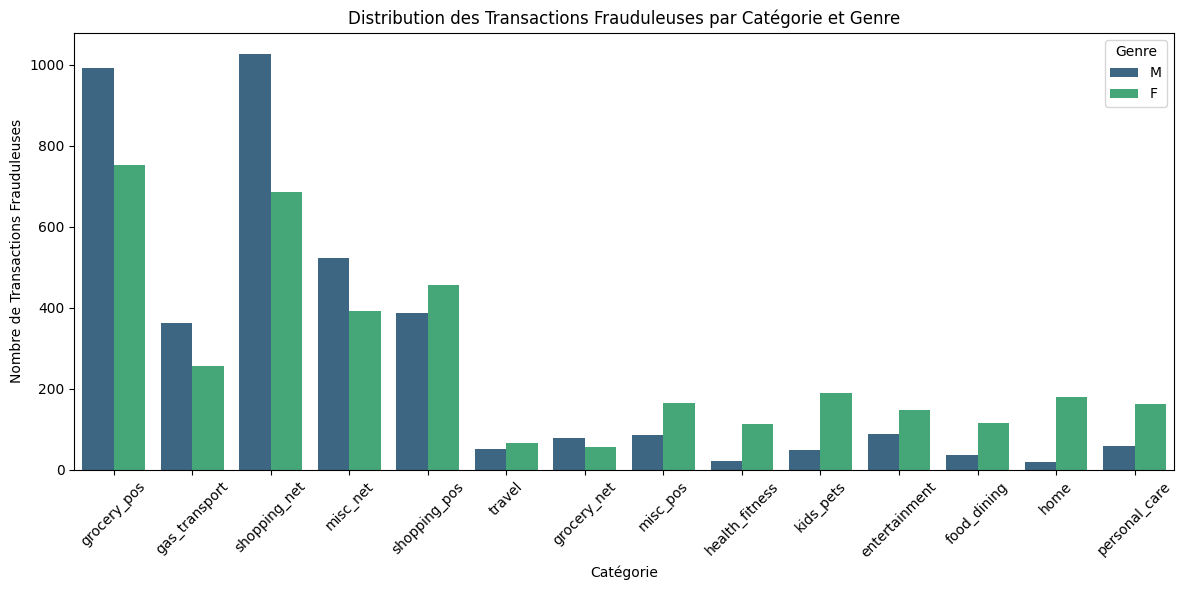

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='category', hue='gender', data=df_train_fraud, palette='viridis')
plt.title('Distribution des Transactions Frauduleuses par Catégorie et Genre')
plt.xlabel('Catégorie')
plt.ylabel('Nombre de Transactions Frauduleuses')
plt.legend(title='Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

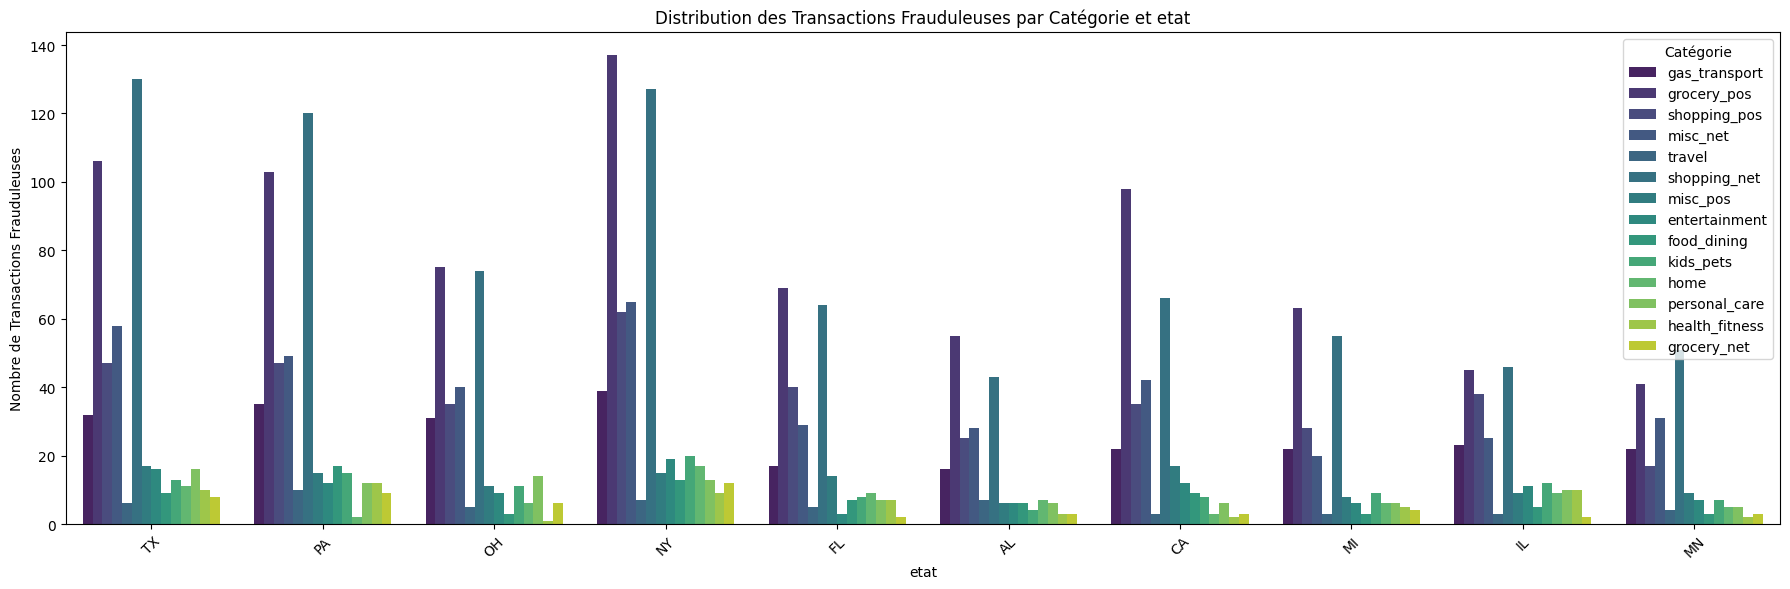

In [ ]:
plt.figure(figsize=(18, 6))
sns.countplot(x='state', hue='category', data=df_train_fraud[df_train_fraud['state'].isin(df_train_fraud['state'].value_counts().nlargest(10).index)], palette='viridis')
plt.title('Distribution des Transactions Frauduleuses par Catégorie et etat')
plt.xlabel('etat')
plt.ylabel('Nombre de Transactions Frauduleuses')
plt.legend(title='Catégorie')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

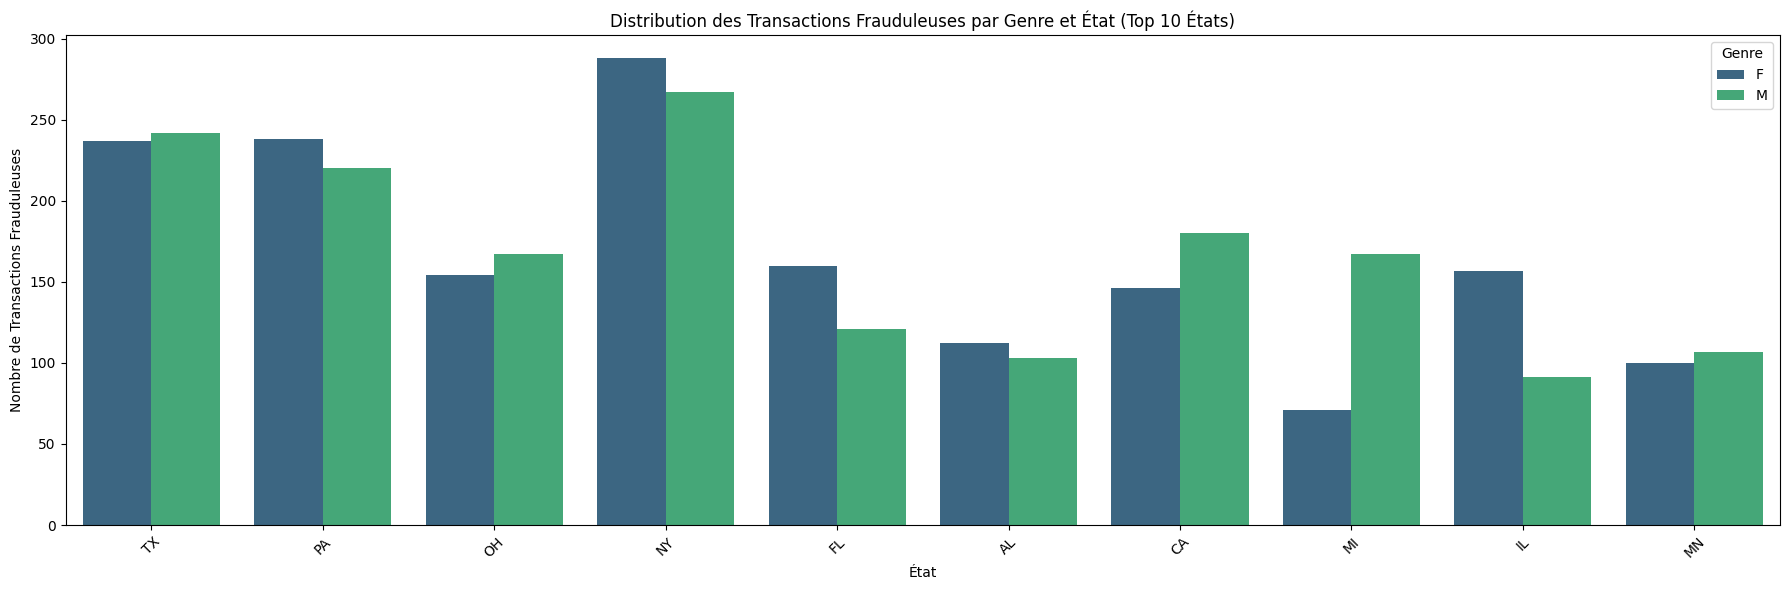

In [ ]:
plt.figure(figsize=(18, 6))
sns.countplot(x='state', hue='gender', data=df_train_fraud[df_train_fraud['state'].isin(df_train_fraud['state'].value_counts().nlargest(10).index)], palette='viridis')
plt.title('Distribution des Transactions Frauduleuses par Genre et État (Top 10 États)')
plt.xlabel('État')
plt.ylabel('Nombre de Transactions Frauduleuses')
plt.legend(title='Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

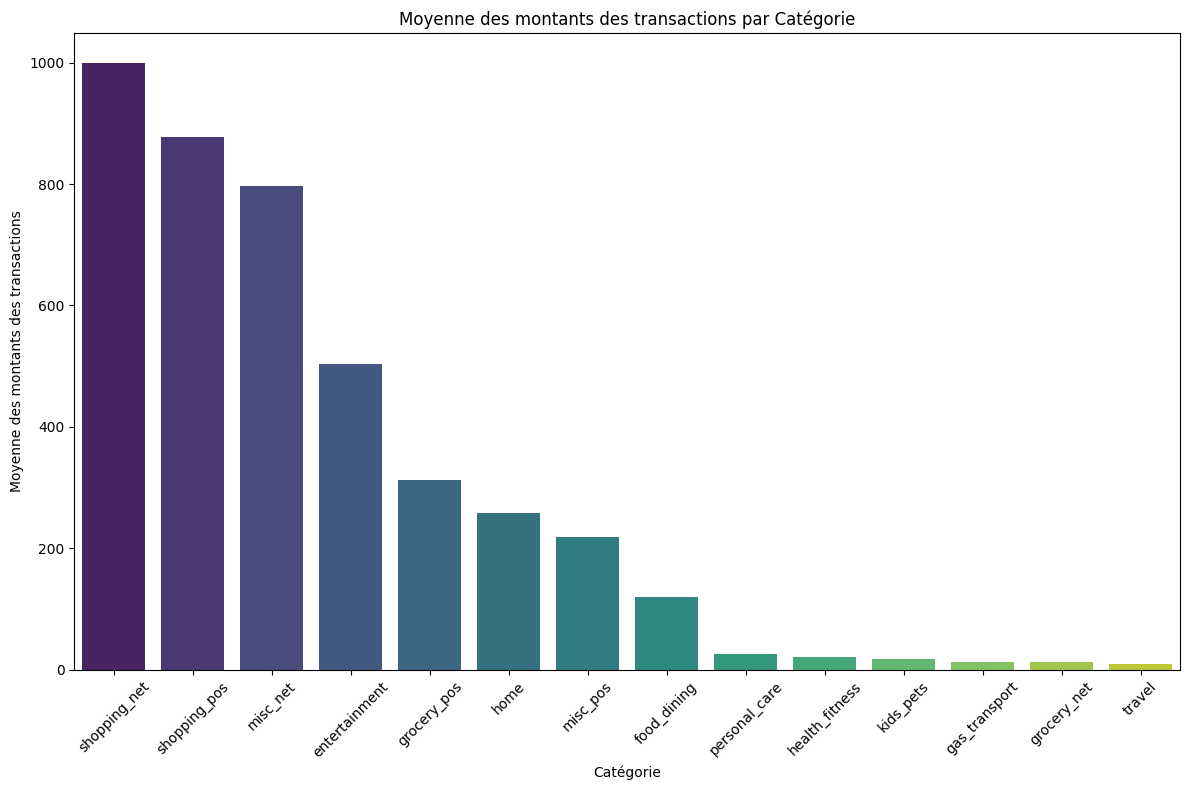

In [ ]:
average_amount_by_category = df_train_fraud.groupby('category')['transaction_amount'].mean().reset_index()
average_amount_by_category.columns = ['Category', 'Average Transaction Amount']

average_amount_by_category = average_amount_by_category.sort_values(by='Average Transaction Amount', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Category', y='Average Transaction Amount',
            data=average_amount_by_category,
            palette='viridis',
            order=average_amount_by_category['Category'])
plt.title('Moyenne des montants des transactions par Catégorie')
plt.xlabel('Catégorie')
plt.ylabel('Moyenne des montants des transactions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


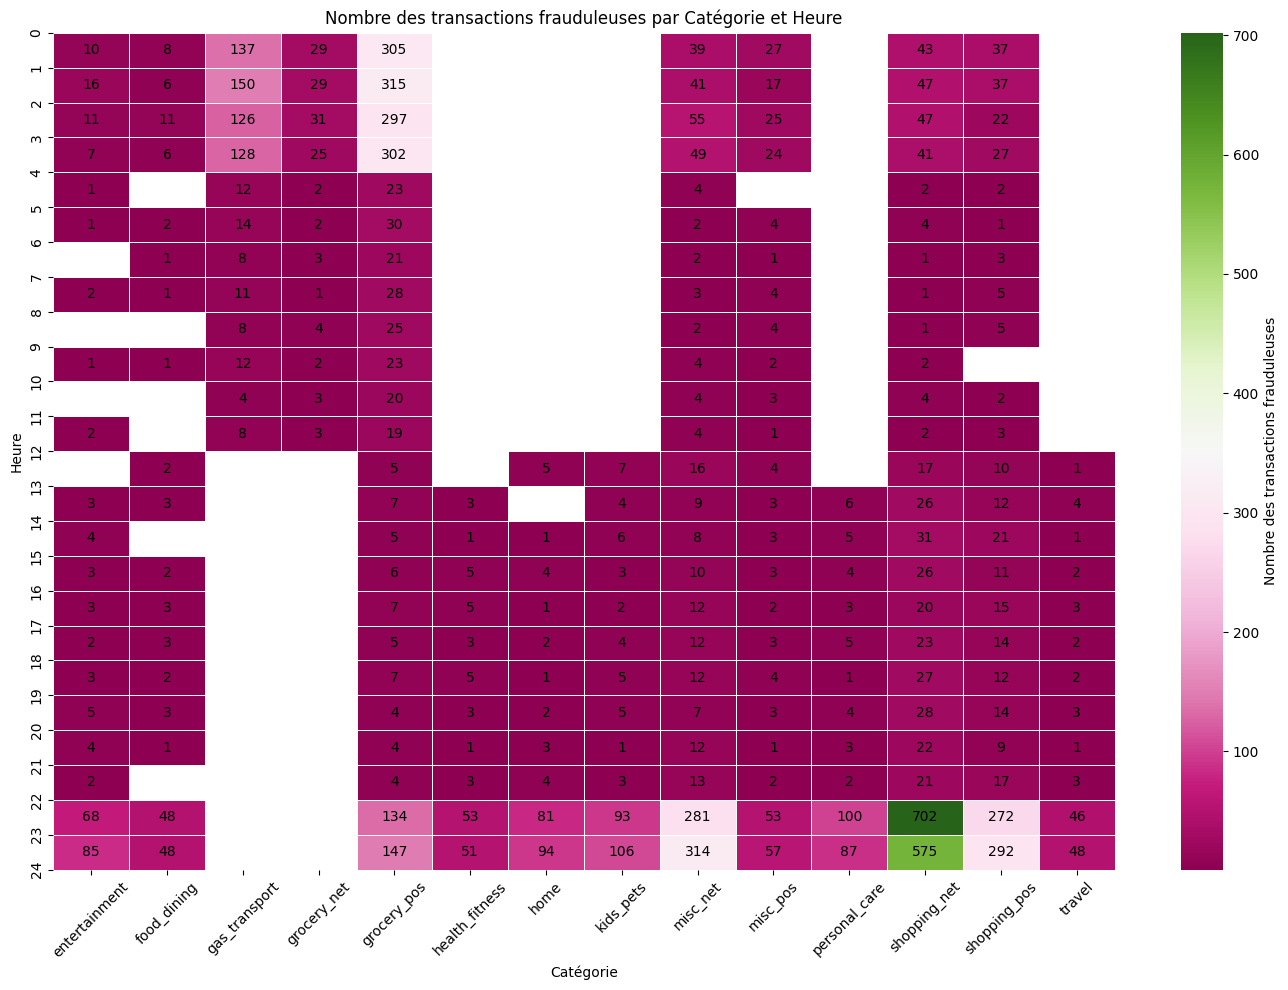

In [ ]:
fraud_counts = df_train_fraud.groupby(['category', 'transaction_hour']).size().reset_index(name='fraud_count')

heatmap_data = fraud_counts.pivot(index='transaction_hour', columns='category', values='fraud_count')

plt.figure(figsize=(14, 10))
ax = sns.heatmap(heatmap_data, cmap='PiYG', annot=True, fmt='.0f', linewidths=0.5, cbar_kws={'label': 'Nombre des transactions frauduleuses'}, annot_kws={'color': 'black'})
plt.title('Nombre des transactions frauduleuses par Catégorie et Heure')
plt.xlabel('Catégorie')
plt.ylabel('Heure')
plt.xticks(rotation=45)
ax.set_yticks(range(0, 25))
ax.set_yticklabels(range(0, 25))
plt.tight_layout()

plt.show()


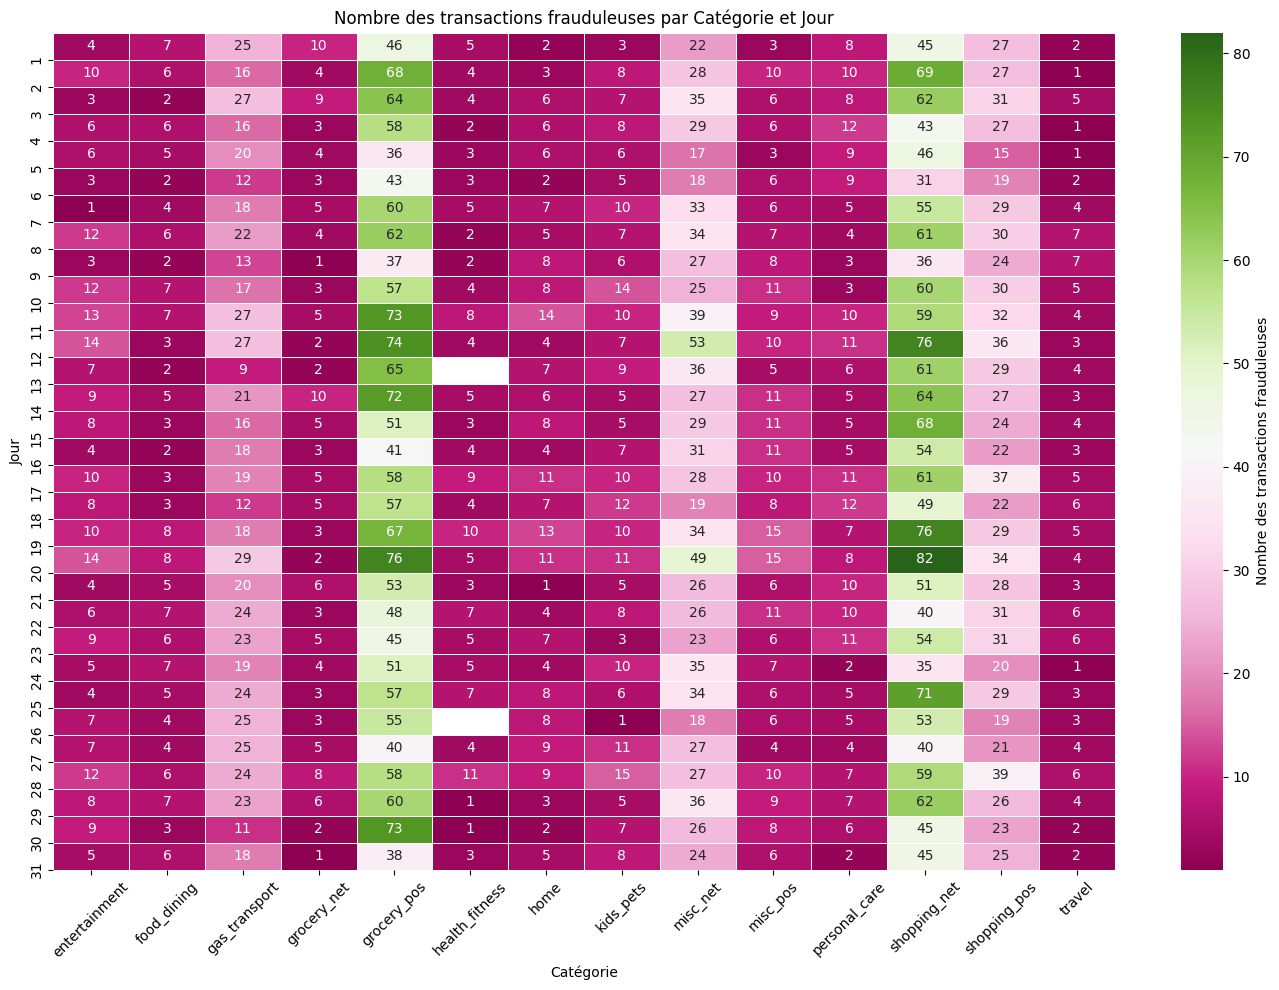

In [ ]:
fraud_counts = df_train_fraud.groupby(['category', 'transaction_day']).size().reset_index(name='fraud_count')

heatmap_data = fraud_counts.pivot(index='transaction_day', columns='category', values='fraud_count')

plt.figure(figsize=(14, 10))
ax = sns.heatmap(heatmap_data, cmap='PiYG', annot=True, fmt='.0f', linewidths=0.5, cbar_kws={'label': 'Nombre des transactions frauduleuses'})
plt.title('Nombre des transactions frauduleuses par Catégorie et Jour')
plt.xlabel('Catégorie')
plt.ylabel('Jour')
ax.set_yticks(range(1, 32))
ax.set_yticklabels(range(1, 32))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

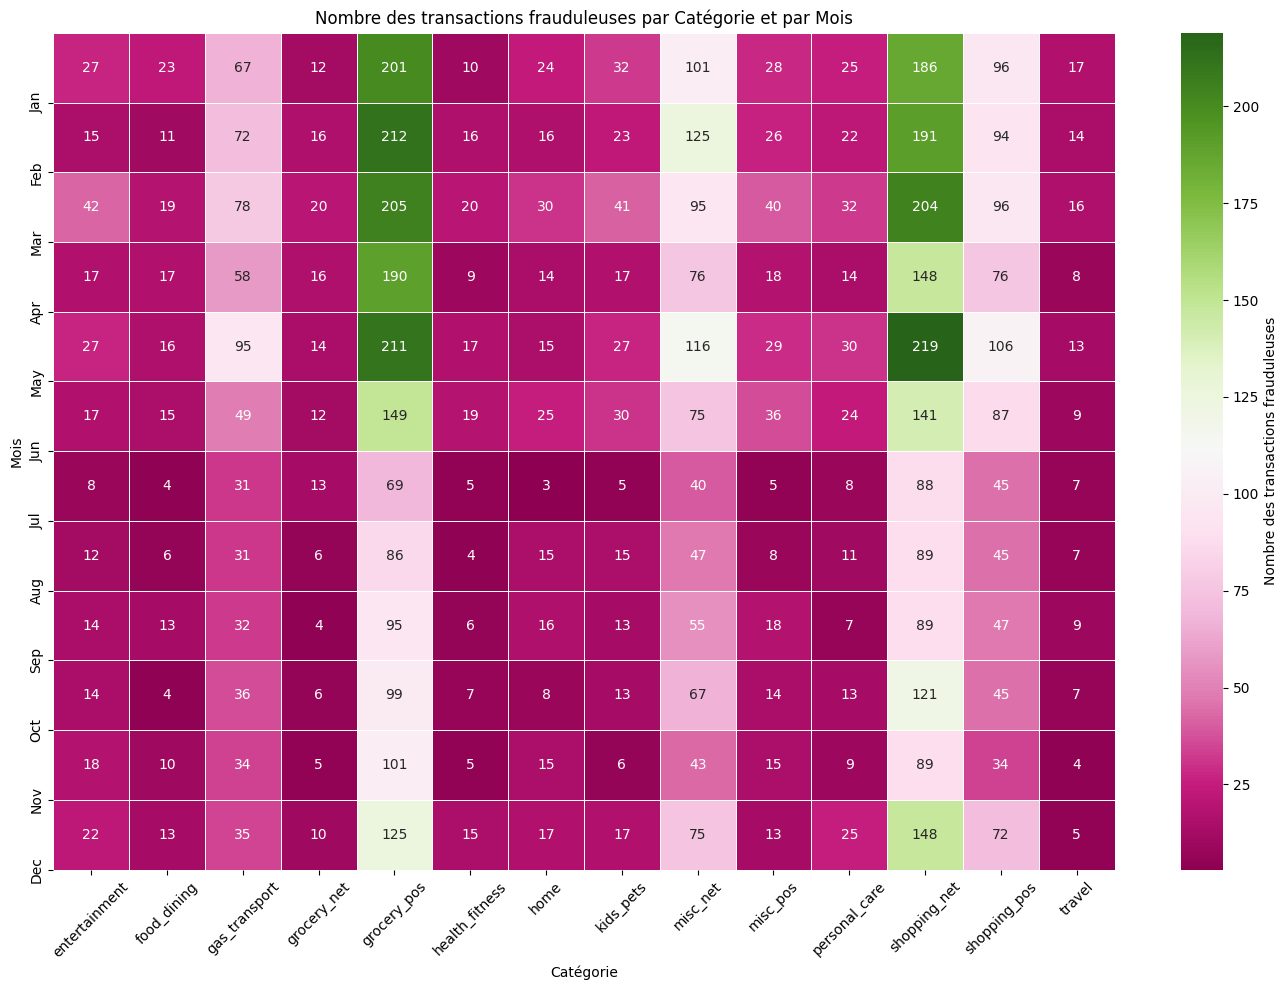

In [ ]:
fraud_counts = df_train_fraud.groupby(['category', 'transaction_month']).size().reset_index(name='fraud_count')

heatmap_data = fraud_counts.pivot(index='transaction_month', columns='category', values='fraud_count')

plt.figure(figsize=(14, 10))
ax = sns.heatmap(heatmap_data, cmap='PiYG', annot=True, fmt='.0f', linewidths=0.5, cbar_kws={'label': 'Nombre des transactions frauduleuses'})
plt.title('Nombre des transactions frauduleuses par Catégorie et par Mois')
plt.xlabel('Catégorie')
plt.ylabel('Mois')
ax.set_yticks(range(1, 13))
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

##Distribution de la variable cible

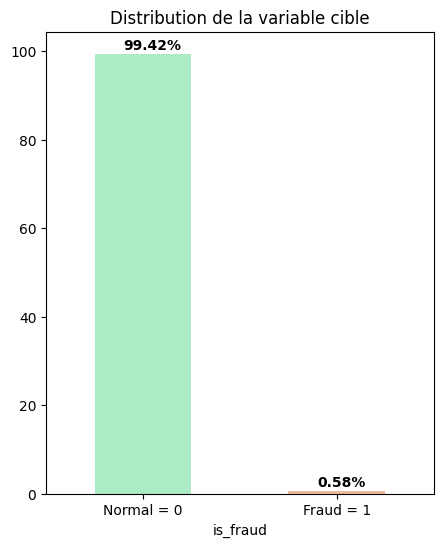

In [ ]:
dist_target = df_train['is_fraud'].value_counts(normalize=True) * 100
dist_target.plot(kind='bar', color=['#abebc6','#edbb99'], figsize=(5, 6))
plt.xticks(range(2), ['Normal = 0', 'Fraud = 1'], rotation=0)
for i, v in enumerate(dist_target):
    plt.text(i - 0.1, v + 1, f'{v:.2f}%', fontweight='bold')
plt.title('Distribution de la variable cible')

plt.show()

**Imbalanced dataset**


*   Le nombre des transactions frauduleuses est négligeable devant le nombre des transactions valides

#Scaling & encoding

###Scaling

In [ ]:
features_to_scale = ['transaction_amount', 'city_population', 'age', 'transaction_distance']
scaler = StandardScaler()
df_train[features_to_scale] = scaler.fit_transform(df_train[features_to_scale])
df_test[features_to_scale] = scaler.transform(df_test[features_to_scale])

In [ ]:
df_train.describe()

,transaction_time,transaction_amount,zip,city_population,is_fraud,age,transaction_hour,transaction_day,transaction_month,transaction_distance
count,1296675,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,2019-10-03 12:47:28.070214144,-9.447052e-18,4.880067e+04,-1.350753e-18,5.788652e-03,-1.756582e-16,1.280486e+01,1.558798e+01,6.142150e+00,1.600842e-15
min,2019-01-01 00:00:18,-4.325897e-01,1.257000e+03,-2.940871e-01,0.000000e+00,-1.867957e+00,0.000000e+00,1.000000e+00,1.000000e+00,-2.688067e+00
25%,2019-06-03 19:12:22.500000,-3.786337e-01,2.623700e+04,-2.917027e-01,0.000000e+00,-7.758157e-01,7.000000e+00,8.000000e+00,3.000000e+00,-7.048439e-01
50%,2019-10-03 07:35:47,-1.424127e-01,4.817400e+04,-2.860297e-01,0.000000e+00,-1.435234e-01,1.400000e+01,1.500000e+01,6.000000e+00,1.146628e-01
75%,2020-01-28 15:02:55.500000,7.977349e-02,7.204200e+04,-2.268423e-01,0.000000e+00,6.612123e-01,1.900000e+01,2.300000e+01,9.000000e+00,7.440769e-01
max,2020-06-21 12:13:37,1.801352e+02,9.978300e+04,9.332066e+00,1.000000e+00,2.845495e+00,2.300000e+01,3.100000e+01,1.200000e+01,2.274652e+00
std,NaN,1.000000e+00,2.689322e+04,1.000000e+00,7.586269e-02,1.000000e+00,6.817824e+00,8.829121e+00,3.417703e+00,1.000000e+00


In [ ]:
df_test.describe()

,transaction_time,transaction_amount,zip,city_population,is_fraud,age,transaction_hour,transaction_day,transaction_month,transaction_distance
count,555719,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000
mean,2020-10-02 01:54:25.166780672,-0.005977,48842.628015,-0.001995,0.003860,0.051366,12.809062,16.463904,9.508536,-0.000515
min,2020-06-21 12:14:25,-0.432590,1257.000000,-0.294087,0.000000,-1.752995,0.000000,1.000000,6.000000,-2.683886
25%,2020-08-09 06:10:27.500000,-0.378758,26292.000000,-0.291709,0.000000,-0.718335,7.000000,9.000000,8.000000,-0.706761
50%,2020-10-03 00:59:48,-0.143847,48174.000000,-0.286189,0.000000,-0.086042,14.000000,17.000000,10.000000,0.114243
75%,2020-12-01 03:03:04,0.078963,72011.000000,-0.228972,0.000000,0.718693,19.000000,24.000000,12.000000,0.742185
max,2020-12-31 23:59:34,141.581391,99921.000000,9.332066,1.000000,2.902976,23.000000,31.000000,12.000000,2.270636
std,NaN,0.977731,26855.283328,0.994816,0.062008,1.002023,6.810924,8.955311,1.978205,0.999936


###Encoding

####transaction_time var

In [ ]:
df_train['transaction_year'] = df_train['transaction_time'].dt.year
df_train['transaction_minute'] = df_train['transaction_time'].dt.minute
df_train['transaction_second'] = df_train['transaction_time'].dt.second
df_train['transaction_day_of_week'] = df_train['transaction_time'].dt.dayofweek

df_test['transaction_year'] = df_test['transaction_time'].dt.year
df_test['transaction_minute'] = df_test['transaction_time'].dt.minute
df_test['transaction_second'] = df_test['transaction_time'].dt.second
df_test['transaction_day_of_week'] = df_test['transaction_time'].dt.dayofweek

In [ ]:
df_train.drop('transaction_time', axis = 1, inplace =True)
df_test.drop('transaction_time', axis = 1, inplace =True)

####les vars catégorielles

In [ ]:
encoder = LabelEncoder()

df_train['category'] = encoder.fit_transform(df_train['category'])
df_train['job'] = encoder.fit_transform(df_train['job'])
df_train['city'] = encoder.fit_transform(df_train['city'])
df_train['state'] = encoder.fit_transform(df_train['state'])

df_test['category'] = encoder.fit_transform(df_test['category'])
df_test['job'] = encoder.fit_transform(df_test['job'])
df_test['city'] = encoder.fit_transform(df_test['city'])
df_test['state'] = encoder.fit_transform(df_test['state'])

In [ ]:
gender_mapping = {"F": 0, "M": 1}

df_train["gender_binary"] = df_train["gender"].map(gender_mapping)
df_test["gender_binary"] = df_test["gender"].map(gender_mapping)

In [ ]:
df_train.drop('gender', axis = 1, inplace =True)
df_test.drop('gender', axis = 1, inplace =True)

In [ ]:
df_train.head()

,category,transaction_amount,city,state,zip,city_population,job,is_fraud,age,transaction_hour,transaction_day,transaction_month,transaction_distance,transaction_year,transaction_minute,transaction_second,transaction_day_of_week,gender_binary
0,8,-0.407826,526,27,28654,-0.282589,370,0,-0.890778,0,1,1,0.376362,2019,0,18,1,0
1,4,0.230039,612,47,99160,-0.293670,428,0,-0.315967,0,1,1,-1.732586,2019,0,44,1,0
2,0,0.934149,468,13,83252,-0.280406,307,0,0.603731,0,1,1,0.738140,2019,0,51,1,1
3,2,-0.158132,84,26,59632,-0.287742,328,0,0.316326,0,1,1,0.541322,2019,1,16,1,1
4,9,-0.177094,216,45,24433,-0.293835,116,0,-0.775816,0,1,1,0.361173,2019,3,6,1,1


In [ ]:
df_test.head()

,category,transaction_amount,city,state,zip,city_population,job,is_fraud,age,transaction_hour,transaction_day,transaction_month,transaction_distance,transaction_year,transaction_minute,transaction_second,transaction_day_of_week,gender_binary
0,10,-0.420988,157,39,29209,0.810291,275,0,0.373807,12,21,6,-1.754731,2020,14,25,6,1
1,10,-0.252695,16,43,84002,-0.293163,392,0,-0.890778,12,21,6,0.793729,2020,14,33,6,0
2,5,-0.181336,61,33,11710,-0.179922,259,0,0.201363,12,21,6,-0.290402,2020,14,53,6,0
3,9,-0.064255,764,8,32780,-0.112789,407,0,-0.775816,12,21,6,-1.807478,2020,15,15,6,1
4,13,-0.418929,247,21,49632,-0.290434,196,0,1.063580,12,21,6,1.240234,2020,15,17,6,1


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 18 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   category                 1296675 non-null  int64  
 1   transaction_amount       1296675 non-null  float64
 2   city                     1296675 non-null  int64  
 3   state                    1296675 non-null  int64  
 4   zip                      1296675 non-null  int64  
 5   city_population          1296675 non-null  float64
 6   job                      1296675 non-null  int64  
 7   is_fraud                 1296675 non-null  int64  
 8   age                      1296675 non-null  float64
 9   transaction_hour         1296675 non-null  int32  
 10  transaction_day          1296675 non-null  int32  
 11  transaction_month        1296675 non-null  int32  
 12  transaction_distance     1296675 non-null  float64
 13  transaction_year         1296675 non-null  int3

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   category                 555719 non-null  int64  
 1   transaction_amount       555719 non-null  float64
 2   city                     555719 non-null  int64  
 3   state                    555719 non-null  int64  
 4   zip                      555719 non-null  int64  
 5   city_population          555719 non-null  float64
 6   job                      555719 non-null  int64  
 7   is_fraud                 555719 non-null  int64  
 8   age                      555719 non-null  float64
 9   transaction_hour         555719 non-null  int32  
 10  transaction_day          555719 non-null  int32  
 11  transaction_month        555719 non-null  int32  
 12  transaction_distance     555719 non-null  float64
 13  transaction_year         555719 non-null  int32  
 14  transacti

#X, y split

In [ ]:
X_train = df_train.drop(['is_fraud'], axis = 1)
y_train = df_train['is_fraud']
X_test = df_test.drop(['is_fraud'], axis = 1)
y_test = df_test['is_fraud']
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1296675, 17), (555719, 17), (1296675,), (555719,))

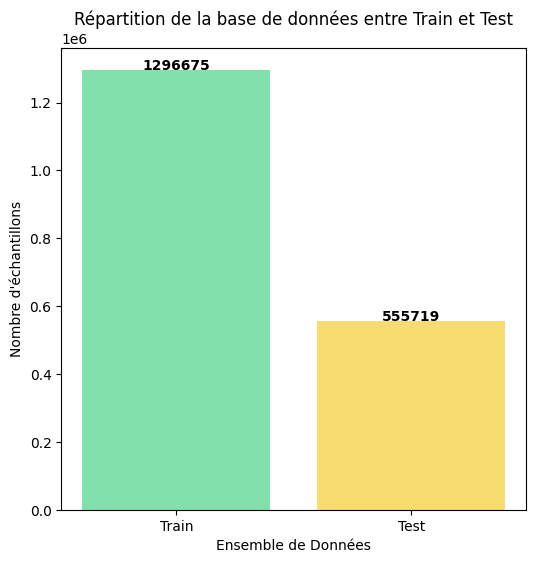

In [ ]:
train_size = len(X_train)
test_size = len(X_test)
data_split = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Count': [train_size, test_size]
})

plt.figure(figsize=(6, 6))
plt.bar(data_split['Dataset'], data_split['Count'], color=['#82E0AA', '#F7DC6F'])

for i in range(len(data_split)):
    plt.text(i, data_split['Count'][i] + 500, str(data_split['Count'][i]), ha='center', fontweight='bold')

plt.title('Répartition de la base de données entre Train et Test')
plt.xlabel('Ensemble de Données')
plt.ylabel('Nombre d\'échantillons')

plt.show()


#Modelling

In [ ]:
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier()
}

In [ ]:
for key, classifier in tqdm(classifiers.items(), desc="Entraînement des classificateurs"):
    classifier.fit(X_train.values, y_train.values)
    training_score = cross_val_score(classifier, X_train.values, y_train.values, cv=5)
    print(classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Entraînement des classificateurs:  25%|██▌       | 1/4 [02:11<06:33, 131.10s/it]

LogisticRegression Has a training score of 99.0 % accuracy score


Entraînement des classificateurs:  50%|█████     | 2/4 [04:00<03:56, 118.34s/it]

DecisionTreeClassifier Has a training score of 100.0 % accuracy score


Entraînement des classificateurs:  75%|███████▌  | 3/4 [45:36<20:04, 1204.17s/it]

RandomForestClassifier Has a training score of 100.0 % accuracy score


Entraînement des classificateurs: 100%|██████████| 4/4 [1:40:23<00:00, 1505.78s/it]

GradientBoostingClassifier Has a training score of 100.0 % accuracy score


In [ ]:
def evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test, class_names=['valid', 'fraud']):
    results = []

    for model_name, model in classifiers.items():

        model.fit(X_train, y_train.values.ravel())

        pred = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)[:, 1]

        acc = round(accuracy_score(y_test, pred), 2)
        precision = round(precision_score(y_test, pred), 2)
        recall = round(recall_score(y_test, pred), 2)
        f1 = round(f1_score(y_test, pred), 2)
        roc_auc = round(roc_auc_score(y_test, pred_proba), 2)

        results.append({
            'Model': model_name,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        })

        matrix = confusion_matrix(y_test, pred)
        dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

        plt.figure(figsize=(6, 4))
        sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
        plt.title(f"Confusion Matrix for {model_name}")
        plt.ylabel("Actuel")
        plt.xlabel("Predicted")
        plt.tight_layout()
        plt.show()

    results_df = pd.DataFrame(results)
    return results_df


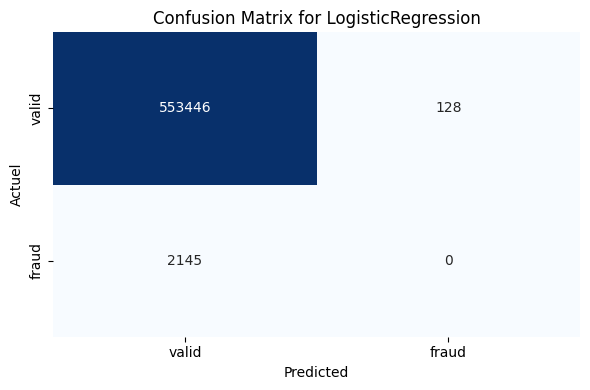

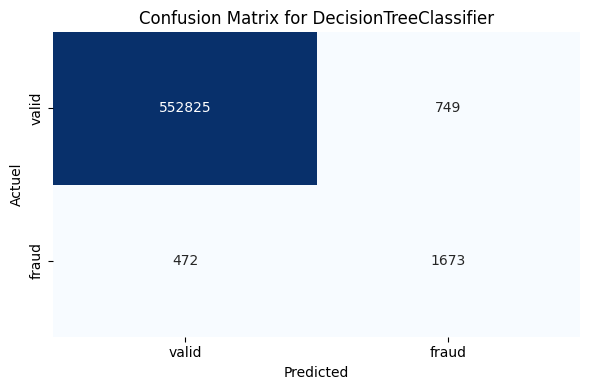

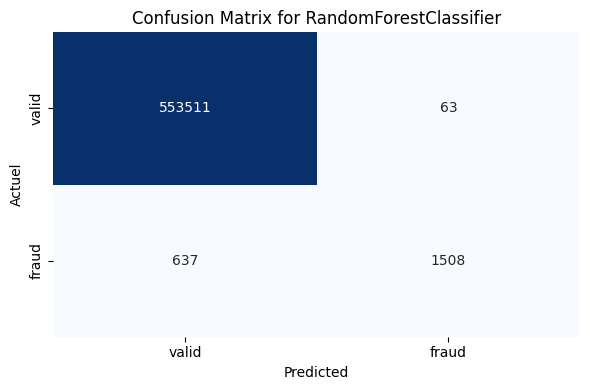

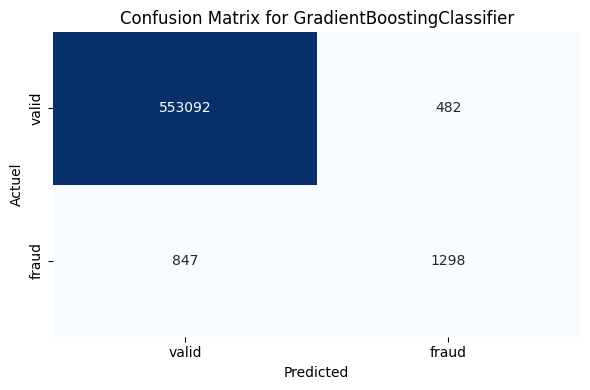

                        Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0          LogisticRegression       1.0       0.00    0.00      0.00     0.68
1      DecisionTreeClassifier       1.0       0.69    0.78      0.73     0.89
2      RandomForestClassifier       1.0       0.96    0.70      0.81     0.97
3  GradientBoostingClassifier       1.0       0.73    0.61      0.66     0.97


In [ ]:
results_df = evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test)
print(results_df)

#Resampling

##Under-sampling

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

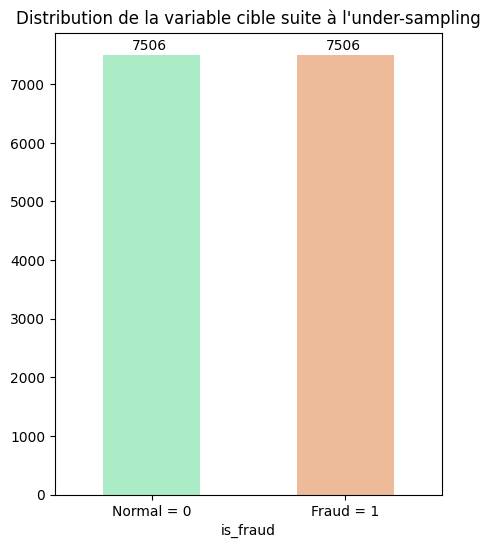

In [ ]:
dist_target_us = pd.Series(y_train_us).value_counts()
dist_target_us.plot(kind='bar', color=['#abebc6','#edbb99'], figsize=(5, 6))
plt.xticks(range(2), ['Normal = 0', 'Fraud = 1'],rotation = 0)
for i, v in enumerate(dist_target_us):
    plt.text(i-0.1, v+80, str(v))
plt.title("Distribution de la variable cible suite à l'under-sampling")
plt.show()

###Modelling

In [ ]:
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier()
}
for key, classifier in classifiers.items():
    print(f"\nParameters of {key}:\n")
    for param, value in classifier.get_params().items():
        print(f"{param}: {value}")


Parameters of LogisticRegression:

C: 1.0
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: None
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False

Parameters of KNearest:

algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 5
p: 2
weights: uniform

Parameters of DecisionTreeClassifier:

ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
random_state: None
splitter: best

Parameters of RandomForestClassifier:

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_scor

In [ ]:
for key, classifier in tqdm(classifiers.items(), desc="Entraînement des classificateurs"):
    classifier.fit(X_train_us.values, y_train_us.values)
    training_score = cross_val_score(classifier, X_train_us.values, y_train_us.values, cv=5)
    print(classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Entraînement des classificateurs:  20%|██        | 1/5 [00:01<00:06,  1.53s/it]

LogisticRegression Has a training score of 66.0 % accuracy score


Entraînement des classificateurs:  40%|████      | 2/5 [00:02<00:03,  1.27s/it]

KNeighborsClassifier Has a training score of 38.0 % accuracy score


Entraînement des classificateurs:  60%|██████    | 3/5 [00:03<00:02,  1.08s/it]

DecisionTreeClassifier Has a training score of 93.0 % accuracy score


Entraînement des classificateurs:  80%|████████  | 4/5 [00:23<00:08,  8.43s/it]

RandomForestClassifier Has a training score of 88.0 % accuracy score


Entraînement des classificateurs: 100%|██████████| 5/5 [00:50<00:00, 10.05s/it]

GradientBoostingClassifier Has a training score of 91.0 % accuracy score


In [ ]:
def evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test, class_names=['valid', 'fraud']):
    results = []

    for model_name, model in classifiers.items():

        model.fit(X_train, y_train.values.ravel())

        pred = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)[:, 1]

        acc = round(accuracy_score(y_test, pred), 2)
        precision = round(precision_score(y_test, pred), 2)
        recall = round(recall_score(y_test, pred), 2)
        f1 = round(f1_score(y_test, pred), 2)
        roc_auc = round(roc_auc_score(y_test, pred_proba), 2)

        results.append({
            'Model': model_name,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        })

        matrix = confusion_matrix(y_test, pred)
        dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

        plt.figure(figsize=(6, 4))
        sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
        plt.title(f"Confusion Matrix for {model_name}")
        plt.ylabel("Actuel")
        plt.xlabel("Predicted")
        plt.tight_layout()
        plt.show()

    results_df = pd.DataFrame(results)
    return results_df


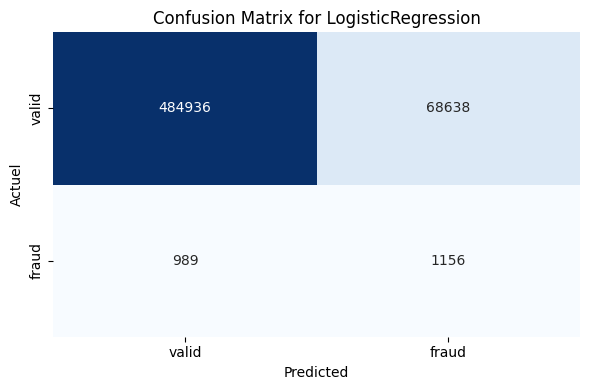

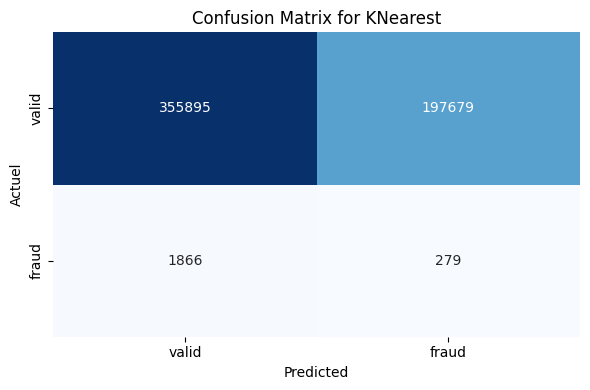

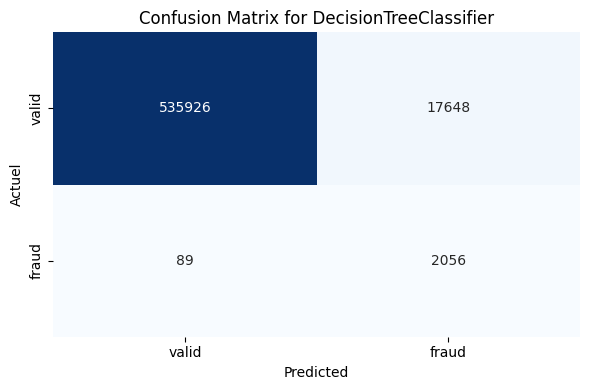

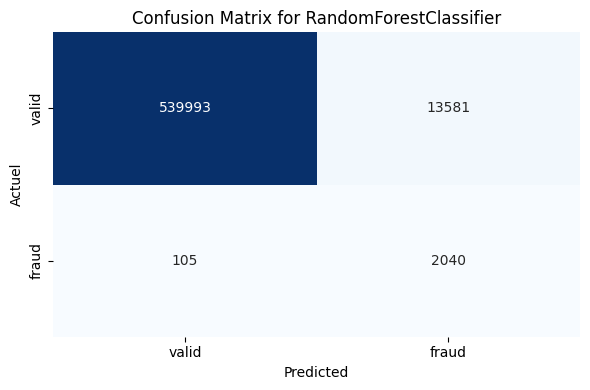

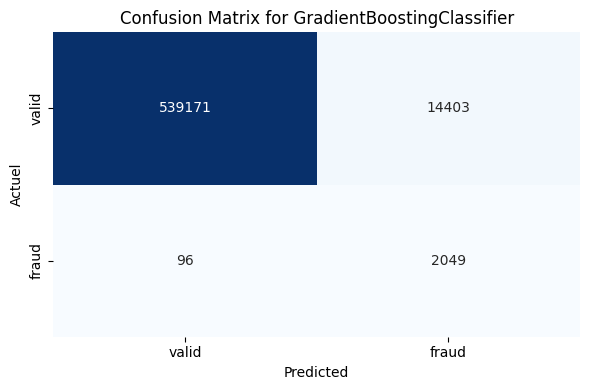

                        Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0          LogisticRegression      0.87       0.02    0.54      0.03     0.73
1                    KNearest      0.64       0.00    0.13      0.00     0.28
2      DecisionTreeClassifier      0.97       0.10    0.96      0.19     0.96
3      RandomForestClassifier      0.98       0.13    0.95      0.23     0.99
4  GradientBoostingClassifier      0.97       0.12    0.96      0.22     0.99


In [ ]:
results_df = evaluate_classifiers(classifiers, X_train_us, y_train_us, X_test, y_test)
print(results_df)

###Hyperparameter tunning

####Logistic regression

Best parameters found:  {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC score:  0.8428178378784221
Test Accuracy: 0.97
Test Precision: 0.08
Test Recall: 0.74
Test F1 Score: 0.14
Test ROC AUC Score: 0.85


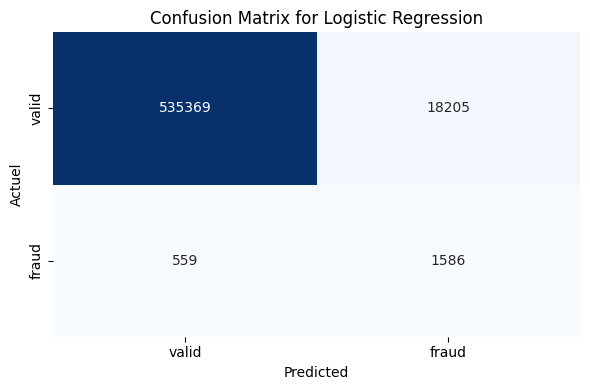

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

lr = LogisticRegression()

# GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_us, y_train_us.values.ravel())

# les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_us = best_model.predict(X_test)


y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred_us)
precision = precision_score(y_test, y_pred_us)
recall = recall_score(y_test, y_pred_us)
f1 = f1_score(y_test, y_pred_us)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_us)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Logistic Regression")
plt.ylabel("Actuel")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

####KNN

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best ROC AUC score:  0.3556294820826317
Test Accuracy: 0.67
Test Precision: 0.00
Test Recall: 0.16
Test F1 Score: 0.00
Test ROC AUC Score: 0.32


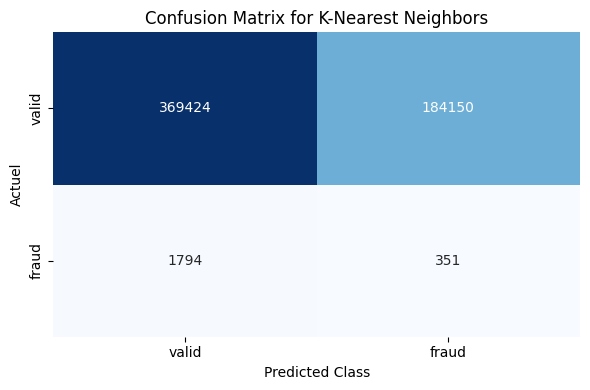

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

# GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_us, y_train_us.values.ravel())

# les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_us = best_model.predict(X_test)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred_us)
precision = precision_score(y_test, y_pred_us)
recall = recall_score(y_test, y_pred_us)
f1 = f1_score(y_test, y_pred_us)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_us)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for K-Nearest Neighbors")
plt.ylabel("Actuel")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()

####DecisionTree

Best parameters found:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best ROC AUC score:  0.9864903800086197
Test Accuracy: 0.97
Test Precision: 0.11
Test Recall: 0.97
Test F1 Score: 0.20
Test ROC AUC Score: 0.99


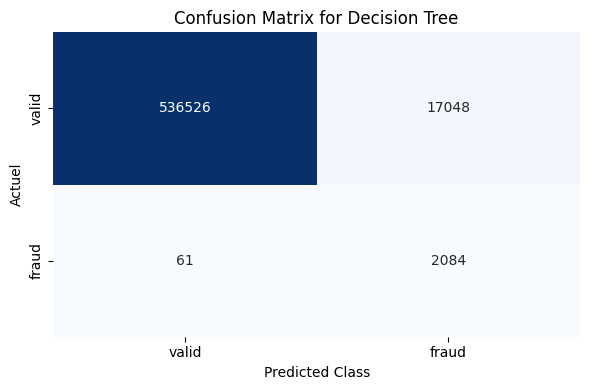

In [ ]:
# Définir la grille de paramètres à tester
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()

# Initialiser GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_us, y_train_us.values.ravel())

#les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_us = best_model.predict(X_test)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred_us)
precision = precision_score(y_test, y_pred_us)
recall = recall_score(y_test, y_pred_us)
f1 = f1_score(y_test, y_pred_us)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_us)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Decision Tree")
plt.ylabel("Actuel")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()


####Random forest

Best parameters found:  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best ROC AUC score:  0.9802911269077914
Test Accuracy: 0.97
Test Precision: 0.12
Test Recall: 0.95
Test F1 Score: 0.21
Test ROC AUC Score: 0.99


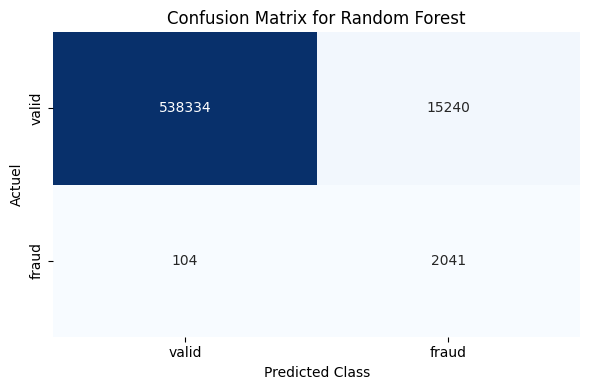

In [ ]:
# Définir la grille de paramètres à tester
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_us, y_train_us.values.ravel())

#les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_us = best_model.predict(X_test)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred_us)
precision = precision_score(y_test, y_pred_us)
recall = recall_score(y_test, y_pred_us)
f1 = f1_score(y_test, y_pred_us)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_us)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Random Forest")
plt.ylabel("Actuel")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()


####Gradient boosting

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best ROC AUC score:  0.9895730137775562
Test Accuracy: 0.98
Test Precision: 0.15
Test Recall: 0.96
Test F1 Score: 0.26
Test ROC AUC Score: 0.99


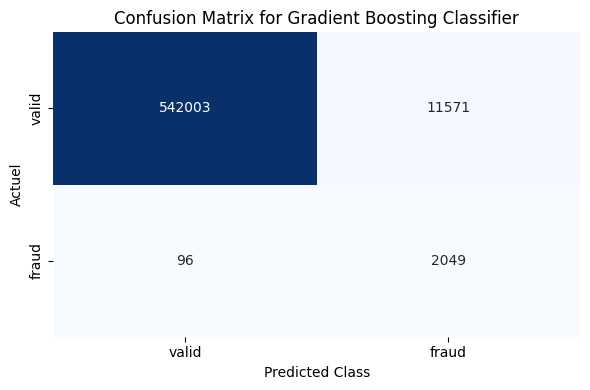

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

gb = GradientBoostingClassifier()

# GridSearchCV
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_us, y_train_us.values.ravel())

#les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_us = best_model.predict(X_test)

# Évaluer les performances du modèle sur les données de test
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred_us)
precision = precision_score(y_test, y_pred_us)
recall = recall_score(y_test, y_pred_us)
f1 = f1_score(y_test, y_pred_us)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_us)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Gradient Boosting Classifier")
plt.ylabel("Actuel")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()

##Over-sampling

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

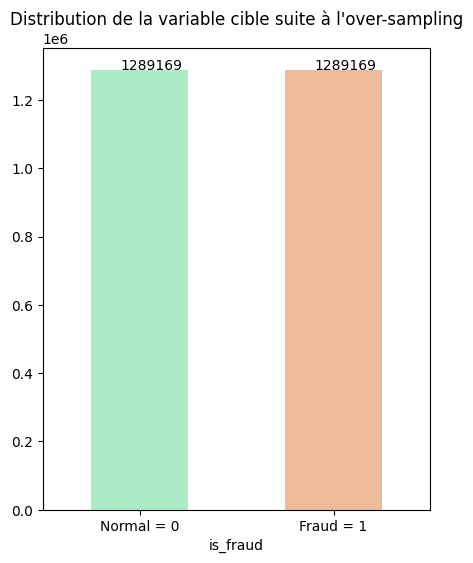

In [ ]:
dist_target_os = pd.Series(y_train_os).value_counts()
dist_target_os.plot(kind='bar', color=['#abebc6','#edbb99'], figsize=(5, 6))
plt.xticks(range(2), ['Normal = 0', 'Fraud = 1'],rotation = 0)
for i, v in enumerate(dist_target_os):
    plt.text(i-0.1, v+80, str(v))
plt.title("Distribution de la variable cible suite à l'over-sampling")
plt.show()

###modelling

In [ ]:
classifierss = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier()
}
for key, classifier in classifierss.items():
    print(f"\nParameters of {key}:\n")
    for param, value in classifier.get_params().items():
        print(f"{param}: {value}")


Parameters of LogisticRegression:

C: 1.0
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: None
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False

Parameters of DecisionTreeClassifier:

ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
random_state: None
splitter: best

Parameters of RandomForestClassifier:

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False

Parameters of GradientBoostingClassifier:

ccp_alpha: 0.0
criterion: friedman_mse
init

In [ ]:
for key, classifier in tqdm(classifierss.items(), desc="Entraînement des classificateurs"):
    classifier.fit(X_train_os.values, y_train_os.values)
    training_score = cross_val_score(classifier, X_train_os.values, y_train_os.values, cv=5)
    print(classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Entraînement des classificateurs:  25%|██▌       | 1/4 [03:22<10:06, 202.30s/it]

LogisticRegression Has a training score of 64.0 % accuracy score


Entraînement des classificateurs:  50%|█████     | 2/4 [06:12<06:06, 183.22s/it]

DecisionTreeClassifier Has a training score of 95.0 % accuracy score


Entraînement des classificateurs:  75%|███████▌  | 3/4 [1:19:56<35:19, 2119.79s/it]

RandomForestClassifier Has a training score of 83.0 % accuracy score


Entraînement des classificateurs: 100%|██████████| 4/4 [3:10:14<00:00, 2853.65s/it]

GradientBoostingClassifier Has a training score of 92.0 % accuracy score


In [ ]:
def evaluate_classifierss(classifierss, X_train, y_train, X_test, y_test, class_names=['valid', 'fraud']):
    results = []

    for model_name, model in classifierss.items():

        model.fit(X_train, y_train.values.ravel())

        pred = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)[:, 1]

        acc = round(accuracy_score(y_test, pred), 2)
        precision = round(precision_score(y_test, pred), 2)
        recall = round(recall_score(y_test, pred), 2)
        f1 = round(f1_score(y_test, pred), 2)
        roc_auc = round(roc_auc_score(y_test, pred_proba), 2)

        results.append({
            'Model': model_name,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        })

        matrix = confusion_matrix(y_test, pred)
        dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

        plt.figure(figsize=(6, 4))
        sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
        plt.title(f"Confusion Matrix for {model_name}")
        plt.ylabel("Actuel")
        plt.xlabel("Predicted")
        plt.tight_layout()
        plt.show()

    results_df = pd.DataFrame(results)
    return results_df

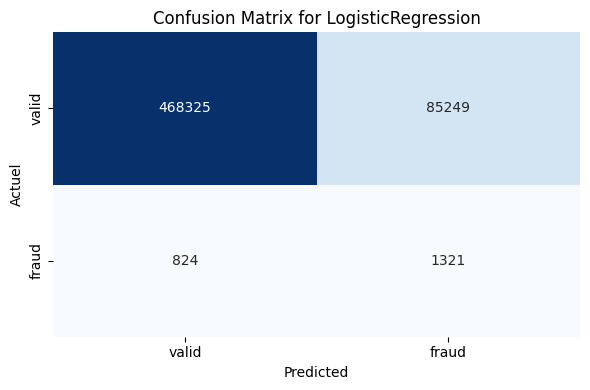

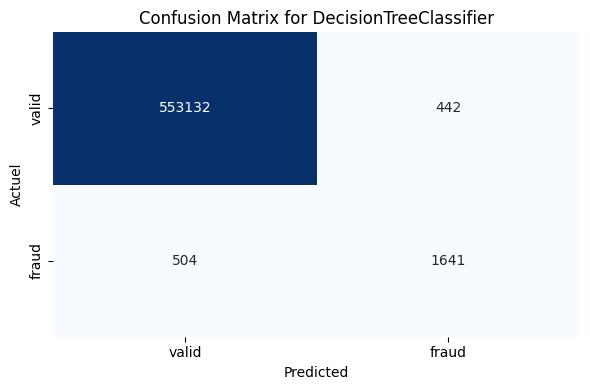

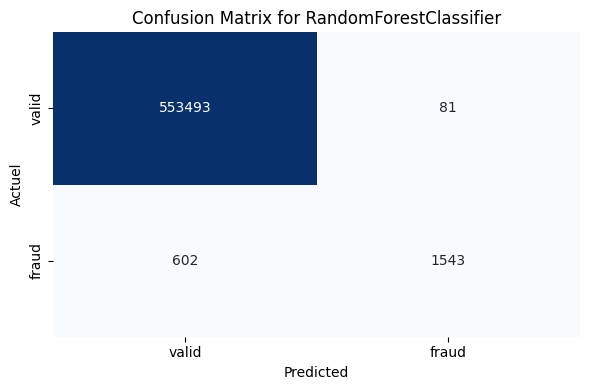

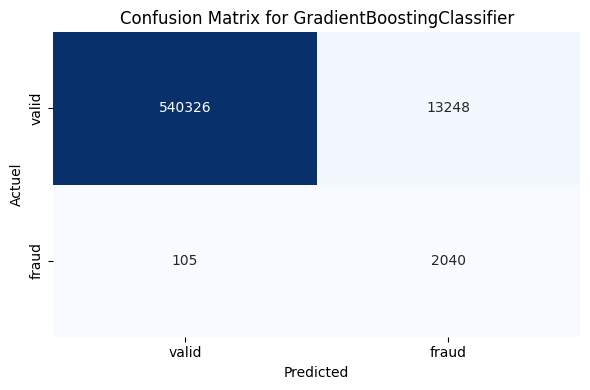

                        Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0          LogisticRegression      0.85       0.02    0.62      0.03     0.78
1      DecisionTreeClassifier      1.00       0.79    0.77      0.78     0.88
2      RandomForestClassifier      1.00       0.95    0.72      0.82     0.98
3  GradientBoostingClassifier      0.98       0.13    0.95      0.23     0.99


In [ ]:
results_df = evaluate_classifierss(classifierss, X_train_os, y_train_os, X_test, y_test)
print(results_df)

###Hyperparameter tunning

####Logistic regression

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

lr = LogisticRegression()

# GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_os, y_train_os.values.ravel())

# les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_os = best_model.predict(X_test)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred_os)
precision = precision_score(y_test, y_pred_os)
recall = recall_score(y_test, y_pred_os)
f1 = f1_score(y_test, y_pred_os)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_os)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Logistic Regression")
plt.ylabel("Actuel")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

####Decision tree

In [ ]:
# Définir la grille de paramètres à tester
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()

# GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_os, y_train_os.values.ravel())

# les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_os = best_model.predict(X_test)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred_os)
precision = precision_score(y_test, y_pred_os)
recall = recall_score(y_test, y_pred_os)
f1 = f1_score(y_test, y_pred_os)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_os)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Decision Tree")
plt.ylabel("Actuel")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


####Random forest

In [ ]:
# Définir la grille de paramètres à tester
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_os, y_train_os.values.ravel())

# les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_os = best_model.predict(X_test)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred_os)
precision = precision_score(y_test, y_pred_os)
recall = recall_score(y_test, y_pred_os)
f1 = f1_score(y_test, y_pred_os)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_os)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Random Forest")
plt.ylabel("Actuel")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


####Gradient Boosting

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

gb = GradientBoostingClassifier()

# GridSearchCV
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_os, y_train_os.values.ravel())

# les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_os = best_model.predict(X_test)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred_os)
precision = precision_score(y_test, y_pred_os)
recall = recall_score(y_test, y_pred_os)
f1 = f1_score(y_test, y_pred_os)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_os)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Gradient Boosting Classifier")
plt.ylabel("Actuel")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()

##Smote

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

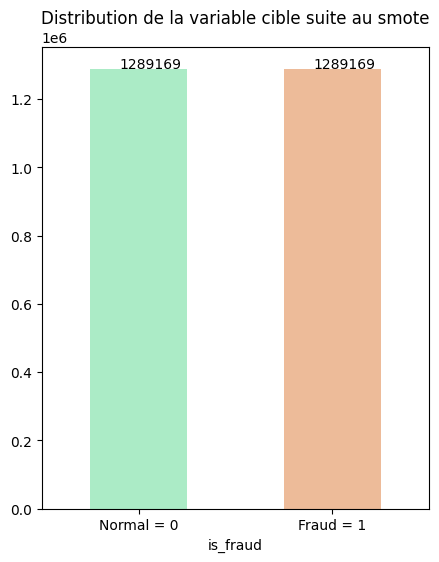

In [ ]:
dist_target_smote = pd.Series(y_train_smote).value_counts()
dist_target_smote.plot(kind='bar', color=['#abebc6','#edbb99'], figsize=(5, 6))
plt.xticks(range(2), ['Normal = 0', 'Fraud = 1'],rotation = 0)
for i, v in enumerate(dist_target_smote):
    plt.text(i-0.1, v+80, str(v))
plt.title("Distribution de la variable cible suite au smote")
plt.show()

###Modelling

In [ ]:
classifierss = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier()
}
for key, classifier in classifierss.items():
    print(f"\nParameters of {key}:\n")
    for param, value in classifier.get_params().items():
        print(f"{param}: {value}")


Parameters of LogisticRegression:

C: 1.0
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: None
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False

Parameters of DecisionTreeClassifier:

ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
random_state: None
splitter: best

Parameters of RandomForestClassifier:

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False

Parameters of GradientBoostingClassifier:

ccp_alpha: 0.0
criterion: friedman_mse
init

In [ ]:
for key, classifier in tqdm(classifierss.items(), desc="Entraînement des classificateurs"):
    classifier.fit(X_train_smote.values, y_train_smote.values)
    training_score = cross_val_score(classifier, X_train_smote.values, y_train_smote.values, cv=5)
    print(classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Entraînement des classificateurs:  25%|██▌       | 1/4 [03:25<10:17, 205.97s/it]

LogisticRegression Has a training score of 68.0 % accuracy score


Entraînement des classificateurs:  50%|█████     | 2/4 [09:46<10:16, 308.45s/it]

DecisionTreeClassifier Has a training score of 72.0 % accuracy score


Entraînement des classificateurs:  75%|███████▌  | 3/4 [2:34:14<1:08:45, 4125.91s/it]

RandomForestClassifier Has a training score of 73.0 % accuracy score


Entraînement des classificateurs: 100%|██████████| 4/4 [4:37:46<00:00, 4166.74s/it]

GradientBoostingClassifier Has a training score of 72.0 % accuracy score


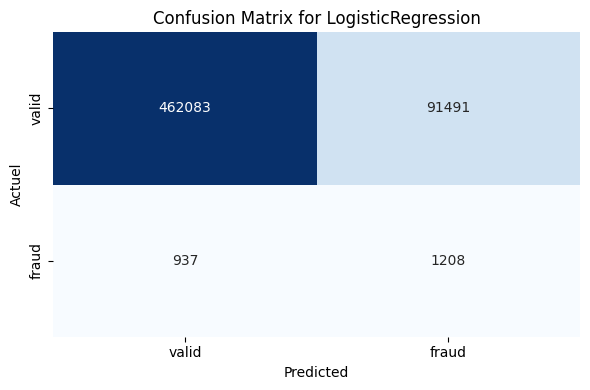

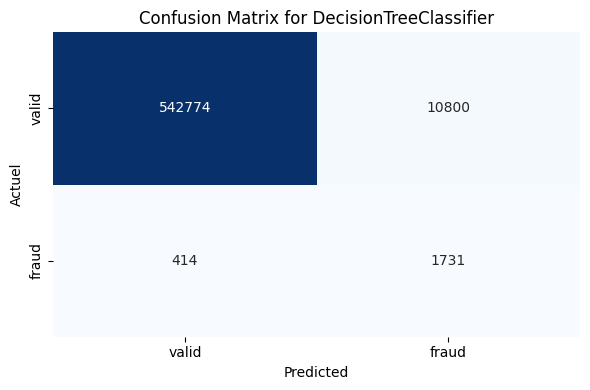

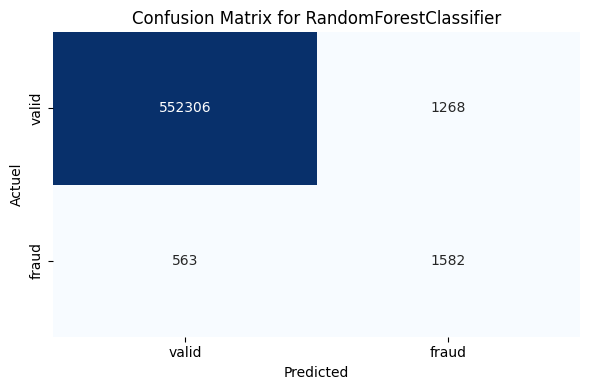

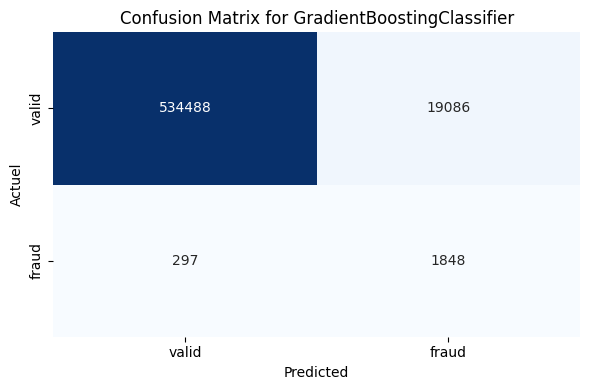

                        Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0          LogisticRegression      0.83       0.01    0.56      0.03     0.70
1      DecisionTreeClassifier      0.98       0.14    0.81      0.24     0.89
2      RandomForestClassifier      1.00       0.56    0.74      0.63     0.97
3  GradientBoostingClassifier      0.97       0.09    0.86      0.16     0.97


In [ ]:
results_df = evaluate_classifierss(classifierss, X_train_smote, y_train_smote, X_test, y_test)
print(results_df)

###Hyperparameter tunning

####Logistic regression

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

lr = LogisticRegression()

# GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote.values.ravel())

# les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_smote = best_model.predict(X_test)

y_pred_proba_smote = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_smote)
acc = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_smote)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Logistic Regression")
plt.ylabel("Actuel")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

####Decision tree

In [ ]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()

# GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote.values.ravel())

# les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_smote = best_model.predict(X_test)

y_pred_proba_smote = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_smote)
acc = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_smote)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Decision Tree")
plt.ylabel("Actuel")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


####Random forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote.values.ravel())

# les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# Prédiction
best_model = grid_search.best_estimator_
y_pred_smote = best_model.predict(X_test)

y_pred_proba_smote = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_smote)
acc = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_smote)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Random Forest")
plt.ylabel("Actuel")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


####Gradient Boosting

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

gb = GradientBoostingClassifier()

# GridSearchCV
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote.values.ravel())

# les meilleurs hyperparamètres trouvés
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# prediction
best_model = grid_search.best_estimator_
y_pred_smote = best_model.predict(X_test)

y_pred_proba_smote = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_smote)
acc = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC Score: {roc_auc:.2f}")

matrix = confusion_matrix(y_test, y_pred_smote)
dataframe = pd.DataFrame(matrix, index=['valid', 'fraud'], columns=['valid', 'fraud'])
plt.figure(figsize=(6, 4))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix for Gradient Boosting Classifier")
plt.ylabel("Actuel")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()

#Conclusion
Le meilleur modéle est :  **Gradient boosting (Oversampling)**
Puisque il a un roc_auc plus élevé et un meilleur recall dans la majorité des cas, ce qui indique une meilleure capacité à identifier les transactions frauduleuses et à discriminer entre les classes.